# Requirements embedding evaluation (315 repositories / train set)

## 1. Loading repository information

In [1]:
!pip install gdown
!gdown 1sJDBLvVRvl4Sx0ICGuoM27pREIg0M756

Downloading...
From (uriginal): https://drive.google.com/uc?id=1sJDBLvVRvl4Sx0ICGuoM27pREIg0M756
From (redirected): https://drive.google.com/uc?id=1sJDBLvVRvl4Sx0ICGuoM27pREIg0M756&confirm=t&uuid=d49386f5-ef6a-4676-bce5-09809a0cfae3
To: /Users/Henry/Documents/PyCharmProjects/PythonSimilarity/Embedding/Embedding_model_315/Evaluation/repo_info.pkl
100%|████████████████████████████████████████| 201M/201M [00:07<00:00, 26.2MB/s]


In [2]:
import pickle

with open("repo_info_train.pkl", "rb") as f:
    repo_info = pickle.load(f)
    f.close()

## 2. Download pre-trained model

In [3]:
!pip3 install torch
!pip3 install transformers
!pip3 install sentence-transformers
# !wget https://raw.githubusercontent.com/microsoft/CodeBERT/master/UniXcoder/unixcoder.py
!curl -O https: // raw.githubusercontent.com/microsoft/CodeBERT/master/UniXcoder/unixcoder.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10352  100 10352    0     0  37885      0 --:--:-- --:--:-- --:--:-- 38483


In [4]:
import torch

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(device)

mps


In [5]:
unixcoder_model_names = [
    "microsoft/unixcoder-base-nine",
    "microsoft/unixcoder-base",
    "microsoft/unixcoder-base-unimodal",
    "Lazyhope/unixcoder-nine-advtest",
    "Lazyhope/unixcoder-clone-detection",
    "Enoch/Unixcoder-Tuned-Code-Search-Py"
]
sentence_transformer_model_names = [
    "sentence-transformers/all-mpnet-base-v2",
    "sentence-transformers/multi-qa-mpnet-base-cos-v1",
    "sentence-transformers/bert-base-nli-mean-tokens",
    "sentence-transformers/paraphrase-multilingual-mpnet-base-v2",
    "sentence-transformers/all-distilroberta-v1",
    "sentence-transformers/distilbert-base-nli-mean-tokens"
]

In [6]:
from unixcoder import UniXcoder
from sentence_transformers import SentenceTransformer

unixcoder_models = {}
sentence_transformer_models = {}

# Initialise unixcoder model
for u_name in unixcoder_model_names:
    unixcoder_models[u_name] = UniXcoder(u_name)
    unixcoder_models[u_name].to(device)

# Initialise sentence transformer model
for s_name in sentence_transformer_model_names:
    sentence_transformer_models[s_name] = SentenceTransformer(model_name_or_path=s_name, device=device)

## 3. Generating requirements embeddings

In [7]:
# Getting code embeddings
def get_code_embeddings(code, model):
    tokens_ids = model.tokenize([code], max_length=512, mode="<encoder-only>")
    source_ids = torch.tensor(tokens_ids).to(device)
    _, embeddings = model(source_ids)
    return embeddings


# Getting other embbeddings
def get_other_embeddings(data_list):
    embeddings = {}

    # Unixcoder model
    for u_name, u_model in tqdm(unixcoder_models.items()):
        print(f" - Using {u_name} model - ")
        embeddings_list = torch.concat([get_code_embeddings(code, u_model) for code in data_list])
        embeddings[u_name] = torch.mean(embeddings_list, dim=0)
        # embeddings[u_name] = embeddings_list

    # Sentence transformer model
    for s_name, s_model in tqdm(sentence_transformer_models.items()):
        print(f" - Using {s_name} model - ")
        embeddings_list = s_model.encode(data_list, convert_to_tensor=True)
        embeddings[s_name] = torch.mean(embeddings_list, dim=0)
        # embeddings[s_name] = embeddings_list

    return embeddings


# Getting embeddings
def get_embeddings(input_data=None, input_mode=None):
    if input_data is None or not input_data:
        return torch.zeros((768,), device=device)

    with torch.no_grad():
        if input_mode == "requirements":
            return get_other_embeddings(input_data)


In [8]:
from tqdm import tqdm

for repo_name, repo_dict in tqdm(repo_info.items()):
    print(f" - Generating requirements embeddings for {repo_name} - ")
    repo_dict["requirements_embeddings"] = get_embeddings(input_data=repo_dict["requirements"],
                                                          input_mode="requirements")

  0%|                                                   | 0/315 [00:00<?, ?it/s]

 - Generating requirements embeddings for jet-admin/jet-bridge - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:21,  4.27s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:07,  2.00s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:08,  2.83s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:03,  1.88s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:12<00:02,  2.34s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:12<00:00,  2.08s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:16,  3.39s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:05<00:09,  2.45s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:05,  1.97s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:05,  2.82s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:12<00:02,  2.36s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|▏                                        | 1/315 [00:25<2:13:11, 25.45s/it]

 - Generating requirements embeddings for patrys/httmock - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:16,  3.30s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:07,  2.51s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:11<00:00,  1.97s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:05,  1.17s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:04<00:10,  2.67s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:04,  1.59s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:03,  1.97s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:08<00:01,  1.53s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  1%|▎                                        | 2/315 [00:49<2:07:47, 24.50s/it]

 - Generating requirements embeddings for pytransitions/transitions - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:05<00:09,  2.37s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:11<00:11,  3.73s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:11<00:04,  2.35s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:16<00:03,  3.22s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:16<00:00,  2.71s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.08it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:03<00:08,  2.17s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:04,  2.03s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:08<00:01,  1.51s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  1%|▍                                        | 3/315 [01:16<2:14:25, 25.85s/it]

 - Generating requirements embeddings for keleshev/schema - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:21,  4.34s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:03,  1.74s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:13<00:00,  2.22s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.30it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:04,  1.02s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.39s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:05<00:01,  1.08s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  1%|▌                                        | 4/315 [01:38<2:05:22, 24.19s/it]

 - Generating requirements embeddings for dylanaraps/pywal - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:07,  1.94s/it]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:04,  2.28s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:13<00:00,  2.30s/it]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.92it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:02<00:05,  1.28s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.85it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:06<00:01,  1.64s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  2%|▋                                        | 5/315 [02:01<2:03:50, 23.97s/it]

 - Generating requirements embeddings for PyCQA/modernize - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:21,  4.33s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:08,  2.85s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:13<00:00,  2.30s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.88it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.19it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.45it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:03,  1.85s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:06<00:01,  1.51s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  2%|▊                                        | 6/315 [02:25<2:02:18, 23.75s/it]

 - Generating requirements embeddings for jaraco/path.py - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:04<00:07,  1.86s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:08,  2.98s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:13<00:00,  2.24s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  2.61it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:04<00:09,  2.29s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:03,  1.75s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:07<00:01,  1.35s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  2%|▉                                        | 7/315 [02:48<2:01:15, 23.62s/it]

 - Generating requirements embeddings for xonsh/xonsh - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:09<00:47,  9.41s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:14<00:26,  6.74s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:23<00:23,  7.92s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:28<00:13,  6.86s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:37<00:07,  7.62s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:43<00:00,  7.21s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:16,  3.27s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:07<00:15,  3.87s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:07,  2.37s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:12<00:06,  3.08s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:12<00:02,  2.12s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  3%|█                                        | 8/315 [03:44<2:54:08, 34.03s/it]

 - Generating requirements embeddings for python-excel/xlrd - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:13,  2.61s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:05,  1.99s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:10<00:00,  1.75s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  9.92it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:03<00:07,  1.96s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:03,  1.52s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:06<00:01,  1.27s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  3%|█▏                                       | 9/315 [04:05<2:31:24, 29.69s/it]

 - Generating requirements embeddings for cloudnativelabs/kube-shell - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:17,  3.53s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.59s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:06,  2.23s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:02,  1.45s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:11<00:00,  1.95s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.49it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:04,  1.08s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.47s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:05<00:01,  1.14s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  3%|█▎                                      | 10/315 [04:25<2:15:48, 26.72s/it]

 - Generating requirements embeddings for ironmussa/Optimus - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:22,  4.55s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:05<00:10,  2.51s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:10<00:10,  3.63s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:11<00:05,  2.68s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:16<00:03,  3.57s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:18<00:00,  3.03s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:15,  3.20s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:06<00:14,  3.51s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:06,  2.04s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:10<00:01,  1.67s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  3%|█▍                                      | 11/315 [04:54<2:18:49, 27.40s/it]

 - Generating requirements embeddings for jazzband/django-taggit - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:03<00:05,  1.29s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:03,  1.77s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:12<00:00,  2.04s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.46it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.34s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:03,  1.69s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:06<00:01,  1.19s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  4%|█▌                                      | 12/315 [05:15<2:09:22, 25.62s/it]

 - Generating requirements embeddings for moggers87/salmon - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:21,  4.39s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:05<00:09,  2.30s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:09,  3.21s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:04,  2.25s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:14<00:03,  3.12s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:15<00:00,  2.64s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:12,  2.46s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:06<00:13,  3.40s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:05,  1.96s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:10<00:01,  1.76s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  4%|█▋                                      | 13/315 [05:42<2:10:27, 25.92s/it]

 - Generating requirements embeddings for glamp/bashplotlib - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:05,  1.39s/it]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:03,  1.61s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:10<00:00,  1.70s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.00it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:00,  2.09it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:04<00:00,  1.11it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  4%|█▊                                      | 14/315 [05:58<1:55:54, 23.10s/it]

 - Generating requirements embeddings for PyCQA/prospector - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:19,  3.98s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:07,  1.84s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:09,  3.07s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.01s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:13<00:02,  2.72s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:13<00:00,  2.26s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:05,  1.11s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.16it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:02,  1.07s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



  5%|█▉                                      | 15/315 [06:17<1:48:37, 21.72s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for twisted/treq - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:06<00:34,  6.85s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:10<00:20,  5.05s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:18<00:18,  6.12s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:22<00:10,  5.46s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:29<00:06,  6.02s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:33<00:00,  5.62s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:10,  2.19s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:05<00:12,  3.13s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:05,  1.92s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:10<00:01,  1.82s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  5%|██                                      | 16/315 [07:01<2:22:30, 28.60s/it]

 - Generating requirements embeddings for bbangert/beaker - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:04<00:07,  1.83s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:03,  1.85s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:13<00:00,  2.21s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.43it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:03<00:07,  1.82s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.12s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:04,  2.21s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:07<00:01,  1.53s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  5%|██▏                                     | 17/315 [07:25<2:14:27, 27.07s/it]

 - Generating requirements embeddings for pypa/bandersnatch - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:18,  3.78s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:07,  1.86s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:08,  2.68s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:03,  1.82s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:12<00:02,  2.76s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:13<00:00,  2.24s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:11,  2.26s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:06<00:14,  3.51s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:06,  2.04s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.34s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



  6%|██▎                                     | 18/315 [07:49<2:09:03, 26.07s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for zachwill/moment - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:17,  3.41s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:07,  2.34s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:11<00:00,  1.88s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.46it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:05<00:11,  2.86s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:03,  1.82s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:07<00:01,  1.35s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  6%|██▍                                     | 19/315 [08:11<2:03:04, 24.95s/it]

 - Generating requirements embeddings for encode/apistar - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.60s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:03,  1.69s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:12<00:00,  2.05s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  6.52it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:03<00:07,  1.96s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:03,  1.76s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:07<00:01,  1.33s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  6%|██▌                                     | 20/315 [08:33<1:58:56, 24.19s/it]

 - Generating requirements embeddings for pyinvoke/invoke - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:19,  3.86s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:06,  1.72s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:08,  2.73s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:03,  1.74s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:12<00:02,  2.59s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:12<00:00,  2.10s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.18it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:03,  1.29s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:04,  2.05s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:07<00:01,  1.42s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  7%|██▋                                     | 21/315 [08:56<1:56:20, 23.74s/it]

 - Generating requirements embeddings for skorokithakis/shortuuid - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.65s/it]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:03,  1.79s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:11<00:00,  1.92s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.73s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:01,  1.01it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:07<00:01,  1.55s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  7%|██▊                                     | 22/315 [09:18<1:53:00, 23.14s/it]

 - Generating requirements embeddings for s3tools/s3cmd - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:18,  3.61s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:05,  1.94s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:10<00:00,  1.73s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  7.15it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:02<00:05,  1.49s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.34s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:05<00:01,  1.14s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  7%|██▉                                     | 23/315 [09:37<1:46:13, 21.83s/it]

 - Generating requirements embeddings for pyenv/pyenv - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:16,  3.40s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:07,  2.38s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:12<00:00,  2.09s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.03it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:02<00:06,  1.60s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:02,  1.04it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:03,  2.00s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:07<00:01,  1.42s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  8%|███                                     | 24/315 [09:59<1:46:40, 21.99s/it]

 - Generating requirements embeddings for stchris/untangle - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:16,  3.30s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:08,  2.71s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:12<00:00,  2.10s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  9.73it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:04<00:10,  2.58s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:03,  1.81s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:07<00:01,  1.46s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  8%|███▏                                    | 25/315 [10:23<1:48:43, 22.49s/it]

 - Generating requirements embeddings for nvdv/vprof - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:19,  3.84s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:07,  1.78s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:08,  2.86s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:03,  1.85s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:13<00:02,  2.80s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:13<00:00,  2.25s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:05<00:25,  5.16s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:09<00:19,  4.78s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:03,  1.89s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



  8%|███▎                                    | 26/315 [10:47<1:50:29, 22.94s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for h2oai/h2o-3 - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:23,  4.62s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:05<00:09,  2.39s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:09,  3.22s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:04,  2.27s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:15<00:03,  3.10s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:15<00:00,  2.65s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:14,  2.99s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:06<00:14,  3.55s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:06,  2.18s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:11<00:01,  1.89s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


  9%|███▍                                    | 27/315 [11:14<1:56:46, 24.33s/it]

 - Generating requirements embeddings for benhamner/Metrics - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.58s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:03,  1.71s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:12<00:00,  1.75s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 


100%|█████████████████████████████████████████████| 6/6 [00:12<00:00,  2.04s/it]

 17%|███████▌                                     | 1/6 [00:00<00:00,  5.97it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:04<00:09,  2.40s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:03,  1.73s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:07<00:01,  1.31s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  9%|███▌                                    | 28/315 [11:36<1:53:06, 23.65s/it]

 - Generating requirements embeddings for jmcarp/robobrowser - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:03<00:05,  1.47s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:03,  1.59s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:12<00:00,  2.03s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  9.54it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.37it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:03,  1.79s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:06<00:01,  1.26s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  9%|███▋                                    | 29/315 [11:57<1:48:55, 22.85s/it]

 - Generating requirements embeddings for WiserTogether/django-remote-forms - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:15,  3.17s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:06,  2.02s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:10<00:00,  1.75s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  7.18it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:02<00:06,  1.73s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.39s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:06<00:01,  1.20s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 10%|███▊                                    | 30/315 [12:17<1:44:17, 21.96s/it]

 - Generating requirements embeddings for mahmoud/boltons - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:19,  3.83s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:06,  1.71s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:09,  3.05s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:03,  1.94s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:13<00:00,  2.17s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.24it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.36s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:03,  1.92s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:07<00:01,  1.37s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 10%|███▉                                    | 31/315 [12:41<1:46:21, 22.47s/it]

 - Generating requirements embeddings for stanfordnlp/stanza - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:19,  3.91s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:07,  1.84s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:08,  2.89s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:03,  1.89s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:12<00:02,  2.71s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:13<00:00,  2.22s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:10,  2.16s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:05,  1.92s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.35s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 10%|████                                    | 32/315 [13:05<1:48:34, 23.02s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for keon/algorithms - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.54s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:03,  1.70s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:12<00:00,  2.05s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.41it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:04<00:10,  2.61s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:04,  2.04s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:08<00:01,  1.50s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 10%|████▏                                   | 33/315 [13:29<1:48:49, 23.15s/it]

 - Generating requirements embeddings for esnme/ultrajson - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:20,  4.04s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:08,  2.70s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:12<00:00,  2.08s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  7.38it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.39it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:03,  1.71s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:05<00:01,  1.22s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 11%|████▎                                   | 34/315 [13:49<1:45:07, 22.45s/it]

 - Generating requirements embeddings for boto/boto3 - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:16,  3.38s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:06,  2.07s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:10<00:00,  1.83s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.06it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.39it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:02,  1.37s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:05<00:01,  1.05s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 11%|████▍                                   | 35/315 [14:08<1:39:18, 21.28s/it]

 - Generating requirements embeddings for geopy/geopy - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.67s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:02,  1.31s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:11<00:02,  2.45s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:11<00:00,  1.89s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.20it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.49it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:02,  1.25s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:04<00:01,  1.01s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 11%|████▌                                   | 36/315 [14:27<1:35:53, 20.62s/it]

 - Generating requirements embeddings for sdispater/pendulum - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.64s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:02,  1.46s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:11<00:00,  1.89s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.24it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:02<00:04,  1.19s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:02,  1.28s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:05<00:01,  1.09s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 12%|████▋                                   | 37/315 [14:47<1:34:37, 20.42s/it]

 - Generating requirements embeddings for omab/python-social-auth - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:05<00:25,  5.14s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:05<00:09,  2.43s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:08,  2.91s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.01s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:14<00:02,  2.81s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:14<00:00,  2.43s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:06,  1.35s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:05<00:11,  2.99s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:05,  1.78s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:10<00:01,  1.81s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 12%|████▊                                   | 38/315 [15:12<1:40:30, 21.77s/it]

 - Generating requirements embeddings for django-guardian/django-guardian - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:03<00:05,  1.41s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:03,  1.66s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:11<00:00,  1.95s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.39it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.12it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:03,  1.72s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:06<00:01,  1.27s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 12%|████▉                                   | 39/315 [15:32<1:38:06, 21.33s/it]

 - Generating requirements embeddings for mongodb/motor - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:18,  3.75s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:06,  1.69s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:07,  2.43s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:03,  1.59s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:11<00:02,  2.55s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:12<00:00,  2.03s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:19,  3.88s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:04<00:08,  2.04s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:03,  1.56s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 13%|█████                                   | 40/315 [15:52<1:35:46, 20.90s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for napalm-automation/napalm - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:19,  3.81s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:07,  1.83s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:07,  2.53s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:03,  1.70s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:12<00:02,  2.71s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:13<00:00,  2.17s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:04,  1.09it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:03<00:08,  2.10s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:03,  1.24s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:04,  2.04s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 13%|█████▏                                  | 41/315 [16:13<1:35:19, 20.87s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for django-crispy-forms/django-crispy-forms - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:16,  3.33s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:07,  2.36s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:11<00:00,  1.90s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  5.68it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.23it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.63it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:06<00:01,  1.55s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 13%|█████▎                                  | 42/315 [16:33<1:33:33, 20.56s/it]

 - Generating requirements embeddings for mymarilyn/clickhouse-driver - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:19,  3.88s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:07,  1.76s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:06,  2.19s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:02,  1.45s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:12<00:02,  2.76s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:12<00:00,  2.09s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:08,  1.62s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:01,  1.59it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:03,  1.52s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 14%|█████▍                                  | 43/315 [16:52<1:30:46, 20.02s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for sdispater/orator - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:18,  3.70s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:06,  1.70s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:08,  2.70s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:03,  1.75s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:12<00:02,  2.54s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:12<00:00,  2.10s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:15,  3.03s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:07<00:14,  3.63s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:02,  1.49s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 14%|█████▌                                  | 44/315 [17:12<1:30:57, 20.14s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for codelucas/newspaper - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:18,  3.74s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.69s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:08,  2.79s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:03,  1.79s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:12<00:02,  2.77s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:13<00:00,  2.18s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:06,  1.33s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:06,  2.07s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:02,  1.36s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 14%|█████▋                                  | 45/315 [17:33<1:31:19, 20.29s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for coleifer/huey - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.52s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:03,  1.72s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:12<00:02,  2.58s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:12<00:00,  2.05s/it]

 17%|███████▌                                     | 1/6 [00:00<00:00,  8.16it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.39s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:04,  2.36s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:08<00:01,  1.63s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 15%|█████▊                                  | 46/315 [17:56<1:35:38, 21.33s/it]

 - Generating requirements embeddings for sympy/sympy - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:09<00:46,  9.24s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:14<00:27,  6.95s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:23<00:23,  7.71s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:28<00:13,  6.89s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:37<00:07,  7.49s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:42<00:00,  7.11s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:17,  3.59s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:07<00:14,  3.70s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:06,  2.29s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:11<00:05,  2.71s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:11<00:01,  1.85s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 15%|█████▉                                  | 47/315 [18:51<2:19:54, 31.32s/it]

 - Generating requirements embeddings for gabrielfalcao/HTTPretty - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:16,  3.31s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.54s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:09,  3.15s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.19s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:14<00:03,  3.24s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:14<00:00,  2.48s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:05<00:25,  5.16s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:08,  2.68s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:03,  1.67s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 15%|██████                                  | 48/315 [19:16<2:11:17, 29.50s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for elapouya/python-docx-template - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.53s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:03,  1.83s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:13<00:00,  2.27s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.28it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.55s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:04,  2.02s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:08<00:01,  1.42s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 16%|██████▏                                 | 49/315 [19:40<2:03:43, 27.91s/it]

 - Generating requirements embeddings for dahlia/wand - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:17,  3.49s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:07,  2.35s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:11<00:00,  1.91s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.06it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.37it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:02,  1.39s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:05<00:01,  1.11s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 16%|██████▎                                 | 50/315 [20:00<1:51:46, 25.31s/it]

 - Generating requirements embeddings for mpdavis/python-jose - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:16,  3.38s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:06,  2.08s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:10<00:00,  1.83s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.21it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.40s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:05<00:01,  1.09s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 16%|██████▍                                 | 51/315 [20:19<1:43:15, 23.47s/it]

 - Generating requirements embeddings for shinux/PyTime - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.69s/it]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:01,  1.05it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:08<00:00,  1.41s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.93it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:05<00:01,  1.25s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 17%|██████▌                                 | 52/315 [20:36<1:33:54, 21.42s/it]

 - Generating requirements embeddings for pymc-devs/pymc3 - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:18,  3.73s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:07,  1.83s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:07,  2.61s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:03,  1.77s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:13<00:02,  2.93s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:13<00:00,  2.29s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:09,  1.90s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:05,  1.84s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:05,  2.51s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 17%|██████▋                                 | 53/315 [21:00<1:37:22, 22.30s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for TheAlgorithms/Python - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:21,  4.40s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:08,  2.15s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:08,  2.95s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:03,  2.00s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:13<00:02,  2.90s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:14<00:00,  2.42s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:06,  1.34s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:05<00:11,  2.97s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:05,  1.81s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:04,  2.31s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 17%|██████▊                                 | 54/315 [21:24<1:39:27, 22.87s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for fabric/fabric - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:19,  3.80s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:06,  1.73s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:07,  2.53s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:03,  1.65s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:11<00:02,  2.34s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:11<00:00,  1.95s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.56it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.31it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:02,  1.23s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:06<00:01,  1.57s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 17%|██████▉                                 | 55/315 [21:43<1:33:56, 21.68s/it]

 - Generating requirements embeddings for mindflayer/python-mocket - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:13,  2.75s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:05,  1.31s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.44s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:01,  1.02it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:07<00:01,  1.40s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.22s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:10,  2.16s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:04<00:09,  2.26s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.41s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 18%|███████                                 | 56/315 [21:56<1:21:57, 18.99s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for benfred/py-spy - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.56it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.63it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.81it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  7.57it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 18%|███████▏                                | 57/315 [21:59<1:01:12, 14.24s/it]

 - Generating requirements embeddings for mikeorr/Unipath - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  6.88it/s]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  6.94it/s]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  8.41it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 18%|███████▋                                  | 58/315 [22:00<44:16, 10.34s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for unoconv/unoconv - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 48.36it/s]


 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 47.29it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 19%|███████▊                                  | 59/315 [22:00<31:11,  7.31s/it]

 - Generating requirements embeddings for google/google-api-python-client - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:07,  1.48s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.64s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.64s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:02,  1.46s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:07<00:01,  1.51s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:08<00:00,  1.49s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:04,  1.23it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.35it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.86it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 19%|████████                                  | 60/315 [22:14<38:40,  9.10s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for sdispater/poetry - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:17,  3.40s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:07,  1.86s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:04,  1.59s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:02,  1.24s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:07<00:01,  1.40s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:08<00:00,  1.43s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:05<00:26,  5.38s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:07,  2.60s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 19%|████████▏                                 | 61/315 [22:34<52:32, 12.41s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for dbader/schedule - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:21,  4.36s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:08,  2.83s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:13<00:00,  2.24s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  1.67it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.15it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:02,  1.29s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:04<00:00,  1.06it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 20%|███████▊                                | 62/315 [22:54<1:02:32, 14.83s/it]

 - Generating requirements embeddings for dimka665/awesome-slugify - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:03<00:05,  1.29s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:06,  2.15s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:10<00:00,  1.68s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:02<00:05,  1.31s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.48s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:06<00:01,  1.14s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 20%|████████                                | 63/315 [23:13<1:07:02, 15.96s/it]

 - Generating requirements embeddings for timothycrosley/isort - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:18,  3.73s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:07,  1.80s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:08,  2.72s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:03,  1.88s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:12<00:02,  2.68s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:13<00:00,  2.21s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:17,  3.58s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:07<00:15,  3.98s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:03,  1.57s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 20%|████████▏                               | 64/315 [23:34<1:13:57, 17.68s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for mobolic/facebook-sdk - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.59s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:03,  1.56s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:10<00:00,  1.79s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 




  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.42it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:04<00:09,  2.30s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:03,  1.75s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:08<00:01,  1.53s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 21%|████████▎                               | 65/315 [23:55<1:17:28, 18.59s/it]

 - Generating requirements embeddings for wemake-services/wemake-python-styleguide - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:05<00:27,  5.51s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:07<00:13,  3.33s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:13<00:13,  4.49s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:14<00:06,  3.20s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:20<00:04,  4.31s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:22<00:00,  3.69s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:19,  3.98s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:08<00:18,  4.53s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:07,  2.65s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:14<00:02,  2.46s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 21%|████████▍                               | 66/315 [24:32<1:40:16, 24.16s/it]

 - Generating requirements embeddings for dirn/When.py - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:19,  3.99s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:07,  2.64s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:13<00:00,  2.27s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  8.31it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:04<00:11,  2.76s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:03,  1.93s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:08<00:01,  1.55s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 21%|████████▌                               | 67/315 [24:58<1:41:36, 24.58s/it]

 - Generating requirements embeddings for miso-belica/sumy - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:22,  4.45s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:07,  1.99s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:03,  1.85s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:14<00:00,  2.35s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.52it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:04<00:10,  2.66s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:03,  1.98s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:08<00:01,  1.61s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 22%|████████▋                               | 68/315 [25:23<1:41:33, 24.67s/it]

 - Generating requirements embeddings for davidaurelio/hashids-python - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:07,  1.86s/it]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:03,  1.81s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:11<00:00,  1.86s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.56it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:04<00:01,  1.13s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 22%|████████▊                               | 69/315 [25:41<1:33:14, 22.74s/it]

 - Generating requirements embeddings for noxrepo/pox - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:24,  4.89s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:06<00:12,  3.13s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:08,  2.83s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:11<00:04,  2.41s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:14<00:02,  2.77s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:15<00:00,  2.65s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 33%|███████████████                              | 2/6 [00:07<00:12,  3.08s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:05,  1.88s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:03,  1.69s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 22%|████████▉                               | 70/315 [26:07<1:36:21, 23.60s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for sqlmapproject/sqlmap - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:23,  4.76s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:05<00:10,  2.56s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:11<00:11,  3.84s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:12<00:05,  2.89s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:17<00:03,  3.56s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:18<00:00,  3.13s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:10,  2.02s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.61s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.04s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:09<00:01,  1.85s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 23%|█████████                               | 71/315 [26:35<1:41:40, 25.00s/it]

 - Generating requirements embeddings for errbotio/errbot - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:22,  4.44s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:08,  2.03s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:09,  3.15s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.04s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:13<00:02,  2.62s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:13<00:00,  2.26s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:11,  2.33s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:02,  1.29it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.48s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 23%|█████████▏                              | 72/315 [26:55<1:35:07, 23.49s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for jonathanslenders/python-prompt-toolkit - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.90it/s]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.60it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.10it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.23it/s]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.74it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.73it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 23%|█████████▎                              | 73/315 [27:00<1:12:35, 18.00s/it]

 - Generating requirements embeddings for jakubroztocil/httpie - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:10,  2.18s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:04,  1.20s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.01s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.24it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:04<00:00,  1.17it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:05<00:00,  1.12it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:07,  1.59s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:06<00:14,  3.66s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:06,  2.08s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:05,  2.60s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 23%|█████████▍                              | 74/315 [27:16<1:10:02, 17.44s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for cdgriffith/Box - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:04<00:06,  1.73s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:03,  1.68s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:12<00:00,  2.07s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  5.62it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:04<00:09,  2.48s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:03,  1.62s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:07<00:01,  1.29s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 24%|█████████▌                              | 75/315 [27:38<1:15:10, 18.79s/it]

 - Generating requirements embeddings for python-openxml/python-docx - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:03<00:05,  1.33s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.52it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.26s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.93it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:02,  1.07s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:04<00:00,  1.11it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 24%|█████████▋                              | 76/315 [27:52<1:09:19, 17.40s/it]

 - Generating requirements embeddings for gleitz/howdoi - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:21,  4.28s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:07,  1.95s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:06,  2.19s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:02,  1.45s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:11<00:02,  2.36s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:11<00:00,  1.95s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:06,  1.20s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:02<00:04,  1.13s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:02,  1.25s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 24%|█████████▊                              | 77/315 [28:10<1:09:29, 17.52s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for vinta/pangu.py - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:07,  1.77s/it]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:01,  1.15it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:04<00:00,  1.33it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  6.55it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 25%|██████████▍                               | 78/315 [28:17<56:04, 14.20s/it]

 - Generating requirements embeddings for derek73/python-nameparser - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.34it/s]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.99it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.76it/s]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.34it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.36it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  3.01it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 25%|██████████▌                               | 79/315 [28:20<43:36, 11.09s/it]

 - Generating requirements embeddings for cobrateam/splinter - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:20,  4.13s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:08<00:17,  4.35s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:15<00:16,  5.36s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:19<00:10,  5.05s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:25<00:05,  5.32s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:29<00:00,  4.96s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:12,  2.54s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.55s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.03s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:04,  2.15s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:07<00:01,  1.47s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 25%|██████████▏                             | 80/315 [28:58<1:14:59, 19.15s/it]

 - Generating requirements embeddings for keras-team/keras - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:16,  3.33s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.60s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.34s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:01,  1.04it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:05<00:00,  1.14it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:06<00:00,  1.04s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:06,  1.32s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.13it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.56it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 26%|██████████▎                             | 81/315 [29:08<1:03:28, 16.27s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for Pylons/deform - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.45it/s]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.37it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.76it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.94it/s]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.67it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  5.29it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 26%|██████████▉                               | 82/315 [29:12<49:36, 12.77s/it]

 - Generating requirements embeddings for facebook/pyre-check - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:18,  3.67s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:06<00:13,  3.36s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:11<00:11,  3.80s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:15<00:08,  4.21s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:20<00:04,  4.35s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:22<00:00,  3.82s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:09<00:47,  9.46s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:09<00:16,  4.17s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:10<00:07,  2.51s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:11<00:04,  2.04s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:12<00:01,  1.50s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 26%|██████████▌                             | 83/315 [29:48<1:15:44, 19.59s/it]

 - Generating requirements embeddings for DiffSK/configobj - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:15,  3.05s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:05,  1.38s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:07,  2.46s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:03,  1.57s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:10<00:00,  1.82s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  5.51it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:03<00:09,  2.30s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:03,  1.57s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:06<00:01,  1.17s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 27%|██████████▋                             | 84/315 [30:08<1:15:39, 19.65s/it]

 - Generating requirements embeddings for binux/pyspider - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:19,  3.98s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:08,  2.10s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:08,  2.91s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.04s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:13<00:02,  2.72s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:13<00:00,  2.28s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:17,  3.41s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:06,  2.16s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:05,  2.58s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 27%|██████████▊                             | 85/315 [30:34<1:22:36, 21.55s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for getnikola/nikola - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:05<00:25,  5.15s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:05<00:09,  2.48s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:11<00:11,  3.82s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:11<00:05,  2.50s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:16<00:03,  3.44s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:17<00:00,  2.87s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:15,  3.18s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:07,  2.35s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:11<00:05,  2.84s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 27%|██████████▉                             | 86/315 [31:03<1:31:31, 23.98s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for dask/dask - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:21,  4.28s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:05<00:08,  2.22s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:10<00:11,  3.70s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:12<00:05,  2.85s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:17<00:03,  3.65s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:18<00:00,  3.12s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:11,  2.21s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:05,  1.69s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:09<00:01,  1.64s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 28%|███████████                             | 87/315 [31:32<1:36:17, 25.34s/it]

 - Generating requirements embeddings for mozilla/unicode-slugify - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:02<00:04,  1.24s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:02,  1.48s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:10<00:00,  1.81s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  7.78it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.41s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:04,  2.09s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:07<00:01,  1.43s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 28%|███████████▏                            | 88/315 [31:53<1:31:15, 24.12s/it]

 - Generating requirements embeddings for devsnd/tinytag - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:03<00:05,  1.33s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:02,  1.49s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:10<00:00,  1.78s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  9.54it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:04<00:11,  2.79s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:04,  2.11s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:08<00:01,  1.66s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 28%|███████████▎                            | 89/315 [32:16<1:29:15, 23.70s/it]

 - Generating requirements embeddings for jazzband/pip-tools - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:23,  4.76s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:05<00:08,  2.17s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:09,  3.18s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.07s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:13<00:02,  2.81s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:14<00:00,  2.37s/it]

 17%|███████▌                                     | 1/6 [00:00<00:00,  5.21it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.58it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:03,  1.77s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:07<00:01,  1.60s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 29%|███████████▍                            | 90/315 [32:41<1:30:27, 24.12s/it]

 - Generating requirements embeddings for gmr/queries - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:04<00:08,  2.07s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:08,  2.89s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:13<00:00,  2.24s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  8.58it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.07it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:02,  1.36s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:05<00:01,  1.11s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 29%|███████████▌                            | 91/315 [33:03<1:27:18, 23.39s/it]

 - Generating requirements embeddings for getsentry/sentry-python - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:06<00:30,  6.06s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:08<00:15,  3.84s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:14<00:14,  4.89s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:17<00:08,  4.11s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:24<00:05,  5.07s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:27<00:00,  4.53s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:19,  3.98s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:07<00:15,  3.97s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:06,  2.31s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:12<00:06,  3.14s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:12<00:02,  2.12s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 29%|███████████▋                            | 92/315 [33:43<1:45:56, 28.50s/it]

 - Generating requirements embeddings for pallets/jinja - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:03<00:05,  1.27s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:06,  2.19s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:08<00:00,  1.49s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  2.50it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.41it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:00,  2.04it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 30%|███████████▊                            | 93/315 [33:55<1:26:37, 23.41s/it]

 - Generating requirements embeddings for rkern/line_profiler - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:09,  1.99s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:04,  1.19s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.14s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:02,  1.12s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:06<00:01,  1.37s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.21s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:06,  1.26s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.23it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 30%|███████████▉                            | 94/315 [34:08<1:15:30, 20.50s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for marrow/mailer - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:06<00:33,  6.67s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:13<00:26,  6.63s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:22<00:23,  7.94s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:26<00:12,  6.47s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:36<00:07,  7.53s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:43<00:00,  7.17s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:07<00:36,  7.25s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:07<00:12,  3.13s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:05,  1.89s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:12<00:06,  3.09s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:13<00:02,  2.11s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 30%|████████████                            | 95/315 [35:05<1:54:56, 31.35s/it]

 - Generating requirements embeddings for gawel/pyquery - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.51s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:06,  2.30s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:02,  1.47s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:10<00:00,  1.83s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  7.13it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:03<00:08,  2.13s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:03,  1.59s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:06<00:01,  1.27s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 30%|████████████▏                           | 96/315 [35:25<1:42:10, 27.99s/it]

 - Generating requirements embeddings for spotify/luigi - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:19,  3.87s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:08,  2.11s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:09,  3.24s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:04,  2.40s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:14<00:03,  3.12s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:15<00:00,  2.55s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:09,  1.92s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:04,  1.65s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.36s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 31%|████████████▎                           | 97/315 [35:50<1:38:12, 27.03s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for devpi/devpi - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:13<01:06, 13.22s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:23<00:46, 11.73s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:34<00:33, 11.00s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:42<00:19,  9.91s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:00<00:12, 12.82s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [01:13<00:00, 12.28s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:06<00:33,  6.66s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:08<00:14,  3.54s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:07,  2.50s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:11<00:04,  2.40s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:12<00:01,  1.76s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 31%|████████████▍                           | 98/315 [37:16<2:42:15, 44.86s/it]

 - Generating requirements embeddings for modoboa/modoboa - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:05<00:27,  5.56s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:07<00:14,  3.61s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:14<00:14,  4.94s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:15<00:06,  3.47s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:21<00:04,  4.24s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:23<00:00,  3.85s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 33%|███████████████                              | 2/6 [00:04<00:08,  2.06s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:03,  1.29s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:04,  2.17s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 31%|████████████▌                           | 99/315 [37:49<2:27:54, 41.08s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for falconry/falcon - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:07<00:36,  7.33s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:11<00:21,  5.42s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:17<00:16,  5.65s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:20<00:09,  4.83s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:28<00:05,  5.70s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:32<00:00,  5.44s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:16,  3.20s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:06<00:13,  3.28s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:06,  2.02s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:11<00:05,  2.81s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:11<00:01,  1.89s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 32%|████████████▍                          | 100/315 [38:33<2:30:39, 42.04s/it]

 - Generating requirements embeddings for django-cache-machine/django-cache-machine - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:15,  3.15s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:05,  1.42s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:07,  2.44s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:03,  1.56s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:11<00:02,  2.37s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:11<00:00,  1.88s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.55it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:03<00:08,  2.21s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:03,  1.30s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:03,  1.97s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:07<00:01,  1.56s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 32%|████████████▌                          | 101/315 [38:55<2:08:06, 35.92s/it]

 - Generating requirements embeddings for martinrusev/imbox - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:07,  1.86s/it]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:03,  1.54s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:11<00:00,  1.92s/it]

 17%|███████▌                                     | 1/6 [00:00<00:00,  8.49it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  3.03it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.00it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 32%|████████████▋                          | 102/315 [39:12<1:48:13, 30.48s/it]

 - Generating requirements embeddings for lektor/lektor - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:17,  3.51s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:09,  2.27s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:05,  1.98s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:03,  1.66s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:10<00:02,  2.12s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:12<00:00,  2.01s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:07,  1.60s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:02<00:03,  1.01it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:01,  1.56it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:05<00:01,  1.08s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 33%|████████████▊                          | 103/315 [39:30<1:34:16, 26.68s/it]

 - Generating requirements embeddings for spotify/annoy - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:02<00:04,  1.10s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.54it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:04<00:00,  1.42it/s]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  8.06it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  8.19it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 11.13it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 33%|████████████▉                          | 104/315 [39:35<1:11:12, 20.25s/it]

 - Generating requirements embeddings for lincolnloop/python-qrcode - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.32it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.96it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.77it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:00,  2.14it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  2.35it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.19it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:00,  3.34it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.16it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 33%|█████████████▋                           | 105/315 [39:41<55:26, 15.84s/it]

 - Generating requirements embeddings for miracle2k/flask-assets - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:09,  1.82s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:03,  1.13it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:02,  1.07it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.54it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.63it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:04<00:00,  1.48it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  7.93it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  3.85it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.45it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 34%|█████████████▊                           | 106/315 [39:47<44:43, 12.84s/it]

 - Generating requirements embeddings for hhatto/nude.py - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:02<00:03,  1.12it/s]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.69it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.68it/s]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  3.51it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.97it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 34%|█████████████▉                           | 107/315 [39:52<36:43, 10.60s/it]

 - Generating requirements embeddings for timofurrer/maya - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.38it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.27it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.73it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.74it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  1.94it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.28it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:11,  2.22s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:04,  1.44s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.08s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 34%|██████████████                           | 108/315 [40:01<34:28,  9.99s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for MicroPyramid/forex-python - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:20,  4.17s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:03,  1.57s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:11<00:00,  1.87s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.50it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:04<00:10,  2.64s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:03,  1.96s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:08<00:01,  1.50s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 35%|██████████████▏                          | 109/315 [40:23<46:45, 13.62s/it]

 - Generating requirements embeddings for codeinthehole/purl - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:14,  2.82s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:06,  2.03s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:10<00:00,  1.72s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:02<00:05,  1.31s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.46s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:06<00:01,  1.14s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 35%|██████████████▎                          | 110/315 [40:42<52:12, 15.28s/it]

 - Generating requirements embeddings for khamidou/lptrace - 
 - Generating requirements embeddings for altair-viz/altair - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:17,  3.55s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:07,  1.77s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:04,  1.59s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.17s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:10<00:02,  2.24s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:10<00:00,  1.78s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:05,  1.07s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.42s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:03,  1.93s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 36%|██████████████▌                          | 112/315 [41:01<42:24, 12.53s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for jendrikseipp/vulture - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:14,  3.00s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:03,  1.68s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:11<00:00,  1.92s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:04<00:08,  2.09s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:03,  1.58s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:06<00:01,  1.20s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 36%|██████████████▋                          | 113/315 [41:21<48:37, 14.44s/it]

 - Generating requirements embeddings for Pylons/waitress - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:03<00:05,  1.42s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:01,  1.00it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:08<00:00,  1.43s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.56s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:03,  1.76s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:07<00:01,  1.39s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 36%|██████████████▊                          | 114/315 [41:39<51:31, 15.38s/it]

 - Generating requirements embeddings for SerpentAI/SerpentAI - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:05<00:27,  5.44s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:06<00:10,  2.60s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:09,  3.05s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:04,  2.02s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:14<00:02,  2.95s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:15<00:00,  2.52s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:19,  3.85s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:10<00:22,  5.51s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:10<00:09,  3.11s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:14<00:06,  3.36s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 37%|██████████████▏                        | 115/315 [42:10<1:05:30, 19.65s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for html5lib/html5lib-python - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:13,  2.80s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:05,  1.33s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:06,  2.17s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:02,  1.43s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:09<00:02,  2.12s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:10<00:00,  1.70s/it]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.52it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.64it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:02,  1.00s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.26it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 37%|██████████████▎                        | 116/315 [42:27<1:02:13, 18.76s/it]

 - Generating requirements embeddings for dmlc/mxnet - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:06<00:32,  6.53s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:09<00:18,  4.64s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:14<00:13,  4.55s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:18<00:08,  4.25s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:26<00:05,  5.61s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:30<00:00,  5.03s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:07<00:39,  7.87s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:08<00:13,  3.43s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:06,  2.17s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:03,  1.82s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 37%|██████████████▍                        | 117/315 [43:07<1:22:39, 25.05s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for django-haystack/pysolr - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:14,  2.81s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:02,  1.42s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.30s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.21it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:04,  1.03s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.99it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  1.76it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 37%|██████████████▌                        | 118/315 [43:20<1:10:43, 21.54s/it]

 - Generating requirements embeddings for aizvorski/scikit-video - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:03<00:05,  1.40s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.43s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:01,  1.04it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:05<00:00,  1.04it/s]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.68it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.70it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  1.83it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 38%|███████████████▍                         | 119/315 [43:29<58:23, 17.87s/it]

 - Generating requirements embeddings for sergree/matchering - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.44it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.42it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.83it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.66it/s]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  3.99it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.94it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 38%|███████████████▌                         | 120/315 [43:33<44:48, 13.79s/it]

 - Generating requirements embeddings for ZoomerAnalytics/xlwings - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:06,  1.33s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.17it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:04,  1.34s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:02,  1.10s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:05<00:01,  1.14s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:06<00:00,  1.07s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:05,  1.17s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:01,  1.64it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.18it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 38%|███████████████▋                         | 121/315 [43:44<41:10, 12.74s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for jazzband/django-pipeline - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  3.39it/s]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  3.66it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  2.66it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.93it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  7.07it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  7.98it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 39%|███████████████▉                         | 122/315 [43:46<31:25,  9.77s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for clips/pattern - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:08,  1.78s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:05,  1.42s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.17s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:02,  1.03s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:05<00:01,  1.13s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.23s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:06,  1.26s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:05<00:10,  2.73s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:04,  1.63s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:05,  2.67s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 39%|████████████████                         | 123/315 [44:04<38:31, 12.04s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for fabianp/memory_profiler - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:03<00:05,  1.43s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:03,  1.52s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:10<00:00,  1.81s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  8.61it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.29it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.47it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.61it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 39%|████████████████▏                        | 124/315 [44:20<42:02, 13.21s/it]

 - Generating requirements embeddings for mitsuhiko/unp - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.48it/s]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.34it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.09it/s]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  7.24it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  6.63it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  6.39it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 40%|████████████████▎                        | 125/315 [44:23<32:23, 10.23s/it]

 - Generating requirements embeddings for stephenmcd/hot-redis - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  2.51it/s]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.08it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.08it/s]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  5.49it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.26it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 40%|████████████████▍                        | 126/315 [44:27<26:01,  8.26s/it]

 - Generating requirements embeddings for henriquebastos/python-decouple - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.41it/s]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.24it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.48it/s]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:00<00:00, 10.18it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  8.94it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 40%|████████████████▌                        | 127/315 [44:29<20:11,  6.44s/it]

 - Generating requirements embeddings for marshmallow-code/webargs - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:06,  1.23s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.27it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.30it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.74it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.22it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:04<00:00,  1.35it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:05,  1.20s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.11it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.20it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 41%|████████████████▋                        | 128/315 [44:37<21:47,  6.99s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for flask-api/flask-api - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.39it/s]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  4.19it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.07it/s]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.59it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  3.89it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 41%|████████████████▊                        | 129/315 [44:41<18:46,  6.05s/it]

 - Generating requirements embeddings for ansible/ansible - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:13,  2.76s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:07,  1.95s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:05,  1.85s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:03,  1.62s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:11<00:02,  2.58s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:13<00:00,  2.20s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:10,  2.05s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:02<00:05,  1.37s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:02,  1.04it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:04,  2.01s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:08<00:01,  1.64s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 41%|████████████████▉                        | 130/315 [45:02<32:54, 10.67s/it]

 - Generating requirements embeddings for amitt001/delegator.py - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:14,  2.86s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:04,  1.62s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:08<00:00,  1.35s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.84it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.04it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.32it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 42%|█████████████████                        | 131/315 [45:17<36:19, 11.84s/it]

 - Generating requirements embeddings for SavinaRoja/PyUserInput - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:14,  2.91s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:05,  1.34s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:05,  1.81s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.19s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:08<00:01,  1.89s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:09<00:00,  1.55s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.36it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.59it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.16it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:05<00:01,  1.17s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 42%|█████████████████▏                       | 132/315 [45:32<38:46, 12.71s/it]

 - Generating requirements embeddings for MongoEngine/mongoengine - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:17,  3.47s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.60s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:06,  2.28s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:02,  1.48s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:09<00:01,  1.70s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:09<00:00,  1.57s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:14,  2.86s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:06,  2.04s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:02,  1.29s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 42%|█████████████████▎                       | 133/315 [45:49<42:40, 14.07s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for pybee/toga - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:16,  3.36s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.51s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:06,  2.15s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:02,  1.38s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:09<00:01,  1.78s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:09<00:00,  1.61s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.67it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.22it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  2.83it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 43%|█████████████████▍                       | 134/315 [46:01<40:59, 13.59s/it]

 - Generating requirements embeddings for google/yapf - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:09,  1.93s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:03,  1.08it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:02,  1.00it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.46it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:04<00:00,  1.54it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:04<00:00,  1.42it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.98it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.64it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.84it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 43%|█████████████████▌                       | 135/315 [46:08<34:40, 11.56s/it]

 - Generating requirements embeddings for Fizzadar/pyinfra - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:04,  1.10it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.27it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.17it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.27it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:04<00:00,  1.06it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:04<00:00,  1.22it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:05,  1.03s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.18it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.12it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 43%|█████████████████▋                       | 136/315 [46:17<32:20, 10.84s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for istrategylabs/django-wordpress - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.55s/it]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.31it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.53it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  7.41it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 43%|█████████████████▊                       | 137/315 [46:23<27:13,  9.18s/it]

 - Generating requirements embeddings for zopefoundation/ZODB - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:10<00:50, 10.01s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:20<00:40, 10.09s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:33<00:34, 11.63s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:47<00:25, 12.58s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:59<00:12, 12.24s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [01:16<00:00, 12.72s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:04<00:20,  4.08s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:08<00:17,  4.26s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:08,  2.94s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:12<00:05,  2.88s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:13<00:02,  2.11s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 44%|█████████████████                      | 138/315 [47:53<1:39:01, 33.57s/it]

 - Generating requirements embeddings for boppreh/mouse - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:12,  2.58s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.10s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:04<00:00,  1.36it/s]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.09it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  5.08it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 44%|█████████████████▏                     | 139/315 [47:59<1:14:27, 25.39s/it]

 - Generating requirements embeddings for justquick/django-activity-stream - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.06it/s]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  4.13it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.58it/s]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:00<00:00, 11.79it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 44%|██████████████████▏                      | 140/315 [48:01<53:33, 18.36s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for benoitc/gunicorn - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:18,  3.78s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:06<00:13,  3.29s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:10<00:10,  3.36s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:13<00:06,  3.41s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:17<00:03,  3.63s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:21<00:00,  3.57s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:12,  2.45s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:02<00:04,  1.24s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:02,  1.12it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:02,  1.00s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:04<00:00,  1.35it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 45%|█████████████████▍                     | 141/315 [48:28<1:00:18, 20.80s/it]

 - Generating requirements embeddings for prabhupant/python-ds - 
 - Generating requirements embeddings for marshmallow-code/marshmallow - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:13,  2.79s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:05,  1.40s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.09s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:01,  1.20it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:05<00:00,  1.24it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:05<00:00,  1.07it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:07,  1.56s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:00,  2.70it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 45%|██████████████████▌                      | 143/315 [48:36<37:15, 13.00s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for coleifer/micawber - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:07,  1.52s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:04,  1.10s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.12s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:01,  1.04it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:05<00:01,  1.00s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:05<00:00,  1.00it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:07,  1.58s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:01,  1.73it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 46%|██████████████████▋                      | 144/315 [48:45<34:21, 12.05s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for getsentry/responses - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.16it/s]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  3.73it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.12it/s]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00, 24.87it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 46%|██████████████████▊                      | 145/315 [48:47<26:42,  9.42s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for joestump/python-oauth2 - 



 33%|███████████████                              | 2/6 [00:00<00:00, 14.23it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 14.92it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 14.78it/s]

 33%|███████████████                              | 2/6 [00:00<00:00, 17.04it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 46%|███████████████████                      | 146/315 [48:47<19:49,  7.04s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for chapmanb/bcbb - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:11,  2.30s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.60s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.50s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.27s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:06<00:01,  1.27s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.32s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 33%|███████████████                              | 2/6 [00:02<00:03,  1.12it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.43it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.24it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:04<00:00,  1.35it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 47%|███████████████████▏                     | 147/315 [49:00<23:51,  8.52s/it]

 - Generating requirements embeddings for Cornices/cornice - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:18,  3.68s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:06<00:13,  3.36s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:11<00:11,  3.83s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:14<00:07,  3.67s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:19<00:03,  3.96s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:22<00:00,  3.77s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:15,  3.15s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:06<00:12,  3.06s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:05,  1.90s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:11<00:01,  1.88s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 47%|███████████████████▎                     | 148/315 [49:34<43:55, 15.78s/it]

 - Generating requirements embeddings for mozilla/bleach - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:04<00:07,  1.94s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:03,  1.68s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:10<00:00,  1.73s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.25it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.47it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:02,  1.14s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:05<00:01,  1.10s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 47%|███████████████████▍                     | 149/315 [49:52<45:52, 16.58s/it]

 - Generating requirements embeddings for selwin/python-user-agents - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:04,  1.00it/s]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.69it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.13it/s]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  9.37it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  3.45it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.93it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 48%|███████████████████▌                     | 150/315 [49:57<35:58, 13.08s/it]

 - Generating requirements embeddings for Suor/django-cacheops - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  3.60it/s]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  3.09it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.76it/s]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.10it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  3.58it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 48%|███████████████████▋                     | 151/315 [50:01<28:27, 10.41s/it]

 - Generating requirements embeddings for burnash/gspread - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:10,  2.17s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.30it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.81it/s]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  3.76it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.38it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 48%|███████████████████▊                     | 152/315 [50:06<24:05,  8.87s/it]

 - Generating requirements embeddings for chapmanb/bcbio-nextgen - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:07,  1.48s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:04,  1.08s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.11s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:01,  1.04it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:05<00:01,  1.09s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:06<00:00,  1.11s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 33%|███████████████                              | 2/6 [00:04<00:06,  1.68s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:03,  1.02s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:05<00:00,  1.28it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 49%|███████████████████▉                     | 153/315 [50:19<26:50,  9.94s/it]

 - Generating requirements embeddings for django/daphne - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:07<00:35,  7.02s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:10<00:19,  4.87s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:17<00:17,  5.83s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:20<00:09,  4.77s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:27<00:05,  5.73s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:32<00:00,  5.37s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:08<00:42,  8.49s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:08<00:14,  3.67s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:06,  2.17s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:14<00:02,  2.12s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 49%|████████████████████                     | 154/315 [51:05<55:59, 20.87s/it]

 - Generating requirements embeddings for stephenmcd/mezzanine - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:15,  3.07s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:05,  1.44s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:09,  3.29s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.08s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:14<00:03,  3.11s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:14<00:00,  2.37s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:04<00:24,  4.95s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:07,  2.63s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:03,  1.68s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 49%|████████████████████▏                    | 155/315 [51:30<58:30, 21.94s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for PySimpleGUI/PySimpleGUI - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:06<00:30,  6.09s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:07<00:12,  3.11s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:10<00:09,  3.05s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:11<00:04,  2.30s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:12<00:01,  1.94s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:13<00:00,  2.23s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:09,  1.93s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:04<00:08,  2.14s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:03,  1.31s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:08<00:01,  1.41s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 50%|████████████████████▎                    | 156/315 [51:51<57:50, 21.82s/it]

 - Generating requirements embeddings for PrefectHQ/prefect - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:18,  3.74s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:08,  2.20s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:05,  1.88s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:02,  1.50s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:10<00:02,  2.03s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:11<00:00,  1.92s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:07,  1.48s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:04<00:10,  2.67s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:04,  1.56s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:08<00:01,  1.53s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 50%|████████████████████▍                    | 157/315 [52:12<56:22, 21.41s/it]

 - Generating requirements embeddings for sunainapai/makesite - 
 - Generating requirements embeddings for BVLC/caffe - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.66s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:08,  2.86s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:03,  1.82s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:13<00:02,  2.92s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:13<00:00,  2.26s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:04,  1.00it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:02,  1.40s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 50%|████████████████████▋                    | 159/315 [52:32<42:19, 16.28s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for django/django - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:24,  4.85s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:05<00:10,  2.55s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:11<00:11,  4.00s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:12<00:05,  2.80s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:18<00:04,  4.01s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:19<00:00,  3.32s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:04<00:22,  4.42s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:08<00:17,  4.25s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:07,  2.44s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:13<00:06,  3.32s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:13<00:02,  2.21s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 51%|████████████████████▊                    | 160/315 [53:06<53:23, 20.67s/it]

 - Generating requirements embeddings for keunwoochoi/kapre - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.52s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:03,  1.85s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:12<00:00,  2.14s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:06<00:31,  6.20s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:11<00:09,  3.24s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:12<00:04,  2.02s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 51%|████████████████████▉                    | 161/315 [53:32<56:11, 21.90s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for awesto/django-shop - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:22,  4.49s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:05<00:09,  2.44s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:11<00:11,  3.86s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:12<00:05,  2.92s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:18<00:03,  3.85s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:19<00:00,  3.18s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:09,  1.99s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:05<00:12,  3.10s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:05,  1.80s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:05,  2.84s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 51%|████████████████████                   | 162/315 [54:02<1:01:26, 24.10s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for emirozer/fake2db - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:18,  3.73s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:08,  2.79s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:12<00:00,  2.01s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.83it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.45s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:04,  2.19s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:08<00:01,  1.58s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 52%|████████████████████▏                  | 163/315 [54:25<1:00:17, 23.80s/it]

 - Generating requirements embeddings for lk-geimfari/mimesis - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:18,  3.78s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:09,  3.23s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:13<00:00,  2.31s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  5.50it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.35it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.92it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 52%|█████████████████████▎                   | 164/315 [54:41<54:44, 21.75s/it]

 - Generating requirements embeddings for pennersr/django-allauth - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.78it/s]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  3.04it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.63it/s]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.10it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  3.80it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  5.06it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 52%|█████████████████████▍                   | 165/315 [54:45<41:06, 16.44s/it]

 - Generating requirements embeddings for pyglet/pyglet - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:07,  1.48s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.17it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.35it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.75it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.50it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:04<00:00,  1.45it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:05,  1.07s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.58it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.94it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 53%|█████████████████████▌                   | 166/315 [54:51<33:17, 13.41s/it]

 - Generating requirements embeddings for dmlc/xgboost - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:07,  1.51s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:04,  1.05s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.01s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.10it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:04<00:00,  1.07it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:05<00:00,  1.08it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.43it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:01,  1.52it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 53%|█████████████████████▋                   | 167/315 [55:02<31:44, 12.87s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for Maratyszcza/PeachPy - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:18,  3.71s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:07,  2.49s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:11<00:00,  1.97s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  2.62it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:05<00:12,  3.16s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:04,  2.22s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:09<00:01,  1.66s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 53%|█████████████████████▊                   | 168/315 [55:26<39:11, 16.00s/it]

 - Generating requirements embeddings for deanmalmgren/textract - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:11,  2.40s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:04,  1.21s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.03s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.31it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:04<00:00,  1.33it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:05<00:00,  1.18it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:09,  1.94s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:02<00:04,  1.25s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:02,  1.21it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.29s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 54%|█████████████████████▉                   | 169/315 [55:38<36:06, 14.84s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for tschellenbach/Stream-Framework - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:03<00:05,  1.45s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:03,  1.54s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:08<00:00,  1.48s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  2.59it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.42it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.74it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 54%|██████████████████████▏                  | 170/315 [55:49<33:16, 13.77s/it]

 - Generating requirements embeddings for pallets/itsdangerous - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:09,  1.82s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:01,  1.56it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.12it/s]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.44it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.42it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  3.56it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 54%|██████████████████████▎                  | 171/315 [55:54<26:41, 11.12s/it]

 - Generating requirements embeddings for wooey/wooey - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:04,  1.02it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.46it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.13it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.42it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.37it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:04<00:00,  1.43it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:08,  1.69s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:04<00:09,  2.41s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.41s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:04,  2.01s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 55%|██████████████████████▍                  | 172/315 [56:07<27:30, 11.54s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for huge-success/sanic - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:05<00:26,  5.29s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:06<00:10,  2.60s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:11<00:11,  3.85s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:12<00:05,  2.63s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:17<00:03,  3.71s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:18<00:00,  3.09s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:14,  2.87s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:06<00:13,  3.27s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:05,  1.94s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:05,  2.56s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 55%|██████████████████████▌                  | 173/315 [56:36<39:42, 16.78s/it]

 - Generating requirements embeddings for chineking/cola - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:16,  3.24s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.54s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:09,  3.23s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.06s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:13<00:02,  2.91s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:13<00:00,  2.30s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:19,  3.95s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:08<00:16,  4.12s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:07,  2.36s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:11<00:05,  2.51s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 55%|██████████████████████▋                  | 174/315 [57:02<45:52, 19.52s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for libvips/pyvips - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:20,  4.02s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:07,  1.83s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:03,  1.88s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:14<00:03,  3.18s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:14<00:00,  2.44s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:15,  3.20s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:07<00:15,  3.88s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:06,  2.20s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:05,  2.56s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 56%|██████████████████████▊                  | 175/315 [57:28<50:13, 21.53s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for srusskih/SublimeJEDI - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:05<00:25,  5.03s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:05<00:10,  2.54s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:10<00:11,  3.74s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:12<00:05,  2.68s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:16<00:03,  3.49s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:17<00:00,  3.00s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:16,  3.28s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:06<00:13,  3.49s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:06,  2.03s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 56%|██████████████████████▉                  | 176/315 [57:57<54:55, 23.71s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for hugapi/hug - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:19,  3.84s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:07,  1.89s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:08,  2.90s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.02s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:13<00:02,  2.93s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:14<00:00,  2.37s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:05,  1.00s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:05<00:12,  3.02s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:05,  1.76s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:04,  2.21s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 56%|███████████████████████                  | 177/315 [58:21<54:58, 23.91s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for openai/gym - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:19,  3.95s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:07,  1.85s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:08,  2.92s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:03,  1.96s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:13<00:02,  2.99s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:14<00:00,  2.36s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:19,  3.87s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:08<00:17,  4.45s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:07,  2.55s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:12<00:05,  2.82s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 57%|███████████████████████▏                 | 178/315 [58:48<56:55, 24.93s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for wtforms/wtforms - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:03<00:05,  1.42s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:03,  1.62s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:12<00:00,  2.05s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  7.24it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.15it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:03,  1.95s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:06<00:01,  1.43s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 57%|███████████████████████▎                 | 179/315 [59:11<54:44, 24.15s/it]

 - Generating requirements embeddings for Supervisor/supervisor - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:18,  3.74s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:09,  3.00s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:13<00:00,  2.28s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  5.31it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:05<00:13,  3.34s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:04,  2.10s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:09<00:01,  1.76s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 57%|███████████████████████▍                 | 180/315 [59:36<55:05, 24.48s/it]

 - Generating requirements embeddings for python-attrs/attrs - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:20,  4.10s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:07,  1.81s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:03,  1.69s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:12<00:00,  2.04s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.42it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.29it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:03,  1.58s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:05<00:01,  1.20s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 57%|███████████████████████▌                 | 181/315 [59:56<52:08, 23.34s/it]

 - Generating requirements embeddings for HypothesisWorks/hypothesis - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:22,  4.42s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:08,  2.14s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:10,  3.35s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:04,  2.19s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:14<00:03,  3.14s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:15<00:00,  2.57s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:19,  3.82s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:07<00:15,  3.88s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:06,  2.21s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:11<00:05,  2.63s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:11<00:01,  1.90s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 58%|██████████████████████▌                | 182/315 [1:00:24<54:33, 24.61s/it]

 - Generating requirements embeddings for quantopian/zipline - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:24,  4.88s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:06<00:10,  2.68s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:11<00:11,  3.96s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:13<00:06,  3.06s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:18<00:03,  3.95s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:19<00:00,  3.32s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:08,  1.61s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:04<00:08,  2.15s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:03,  1.28s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 58%|██████████████████████▋                | 183/315 [1:00:53<56:47, 25.81s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for MechanicalSoup/MechanicalSoup - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:13,  2.63s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:03,  1.83s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:13<00:00,  2.28s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  5.58it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.13it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.33it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 58%|██████████████████████▊                | 184/315 [1:01:12<51:54, 23.78s/it]

 - Generating requirements embeddings for saffsd/langid.py - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:21,  4.21s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:03,  1.26s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:08<00:00,  1.33s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.13it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:02<00:05,  1.43s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:02,  1.18s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:05<00:01,  1.05s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 59%|██████████████████████▉                | 185/315 [1:01:28<46:25, 21.42s/it]

 - Generating requirements embeddings for awslabs/aws-data-wrangler - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:10<00:52, 10.40s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:21<00:42, 10.52s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:32<00:33, 11.04s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:45<00:23, 11.78s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:59<00:12, 12.51s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [01:05<00:00, 10.97s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:10,  2.10s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:07<00:16,  4.04s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:07,  2.55s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:04,  2.46s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:10<00:01,  1.71s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 59%|█████████████████████▊               | 186/315 [1:02:45<1:21:59, 38.14s/it]

 - Generating requirements embeddings for vandersonmota/model_mommy - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:18,  3.79s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:08,  2.74s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:14<00:00,  2.47s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  6.56it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:06<00:15,  3.93s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:06,  2.26s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:11<00:05,  2.99s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:11<00:02,  2.06s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 59%|█████████████████████▉               | 187/315 [1:03:15<1:16:13, 35.73s/it]

 - Generating requirements embeddings for benedekrozemberczki/karateclub - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:20,  4.13s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:07,  1.86s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:10,  3.43s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.18s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:14<00:03,  3.13s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:15<00:00,  2.50s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:08<00:43,  8.66s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:09<00:16,  4.04s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:06,  2.29s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:13<00:06,  3.03s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:15<00:02,  2.54s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 60%|██████████████████████               | 188/315 [1:03:46<1:12:29, 34.25s/it]

 - Generating requirements embeddings for statsmodels/statsmodels - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:05<00:29,  5.84s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:06<00:11,  2.89s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:11<00:11,  3.82s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:12<00:05,  2.65s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:18<00:03,  3.74s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:18<00:00,  3.15s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:07<00:39,  7.88s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:12<00:10,  3.37s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 60%|██████████████████████▏              | 189/315 [1:04:19<1:11:21, 33.98s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for pwaller/pyfiglet - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.57s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:10,  3.40s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:15<00:00,  2.50s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.27it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:06<00:14,  3.67s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:04,  2.49s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:10<00:01,  1.91s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 60%|██████████████████████▎              | 190/315 [1:04:48<1:07:28, 32.38s/it]

 - Generating requirements embeddings for google/pyringe - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:05<00:25,  5.17s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:06<00:10,  2.74s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:11<00:12,  4.04s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:12<00:05,  2.77s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:18<00:04,  4.06s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:19<00:00,  3.33s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:04<00:24,  4.95s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:07,  2.49s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:14<00:06,  3.48s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 61%|██████████████████████▍              | 191/315 [1:05:22<1:08:17, 33.05s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for saltstack/salt - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:07<00:37,  7.51s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:09<00:16,  4.12s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:15<00:15,  5.06s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:17<00:07,  3.86s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:23<00:04,  4.47s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:24<00:00,  4.13s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:04<00:23,  4.63s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:08<00:17,  4.38s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:07,  2.60s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:14<00:07,  3.64s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:14<00:02,  2.44s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 61%|██████████████████████▌              | 192/315 [1:06:02<1:11:56, 35.10s/it]

 - Generating requirements embeddings for web2py/pydal - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:04<00:07,  1.81s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:03,  1.77s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:13<00:00,  2.33s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:06<00:32,  6.44s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:11<00:08,  2.99s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 61%|██████████████████████▋              | 193/315 [1:06:28<1:05:43, 32.32s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for jorgenschaefer/elpy - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:04<00:07,  1.78s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:09,  3.21s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:15<00:00,  2.50s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  6.76it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:05,  1.73s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:04,  2.24s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:08<00:01,  1.57s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 62%|██████████████████████▊              | 194/315 [1:06:55<1:02:04, 30.78s/it]

 - Generating requirements embeddings for lericson/pylibmc - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:19,  3.86s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:07,  2.48s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:12<00:00,  2.14s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.08it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:07<00:16,  4.15s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:05,  2.54s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:11<00:01,  1.97s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 62%|████████████████████████▏              | 195/315 [1:07:22<59:26, 29.72s/it]

 - Generating requirements embeddings for Suor/funcy - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:17,  3.52s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:07,  2.41s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:12<00:00,  2.10s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.04it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.27it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.42s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:05<00:01,  1.16s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 62%|████████████████████████▎              | 196/315 [1:07:44<53:52, 27.16s/it]

 - Generating requirements embeddings for carlosescri/DottedDict - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:17,  3.50s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:03,  1.17s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:08<00:00,  1.45s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  8.37it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.11it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:03,  1.50s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:05<00:01,  1.20s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 63%|████████████████████████▍              | 197/315 [1:08:01<47:39, 24.23s/it]

 - Generating requirements embeddings for mooz/percol - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:19,  3.91s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:09,  3.14s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:14<00:00,  2.38s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:04,  1.50s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:04,  2.22s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:09<00:01,  1.70s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 63%|████████████████████████▌              | 198/315 [1:08:28<48:37, 24.94s/it]

 - Generating requirements embeddings for jfkirk/tensorrec - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:20,  4.12s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:07,  1.83s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:09,  3.31s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.10s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:15<00:00,  2.59s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:05<00:28,  5.68s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:11<00:04,  2.21s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 63%|████████████████████████▋              | 199/315 [1:08:56<50:03, 25.89s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for r0x0r/pywebview - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:12<01:03, 12.70s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:20<00:39,  9.76s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:34<00:34, 11.63s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:44<00:22, 11.24s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:59<00:12, 12.34s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [01:10<00:00, 11.69s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:10<00:50, 10.16s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:11<00:18,  4.69s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:12<00:09,  3.04s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:14<00:05,  2.85s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:15<00:01,  1.98s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 63%|███████████████████████▍             | 200/315 [1:10:21<1:24:01, 43.84s/it]

 - Generating requirements embeddings for zoofIO/flexx - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:21,  4.29s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:08,  2.05s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:09,  3.30s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:04,  2.18s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:15<00:03,  3.22s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:15<00:00,  2.59s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:18,  3.77s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:09<00:18,  4.72s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:08,  2.76s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:13<00:06,  3.25s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 64%|███████████████████████▌             | 201/315 [1:10:51<1:15:25, 39.69s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for davidhalter/jedi-vim - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:07,  1.83s/it]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:04,  2.27s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:13<00:00,  2.33s/it]

 17%|███████▌                                     | 1/6 [00:00<00:00,  7.22it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:05<00:12,  3.24s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:02,  1.35s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:09<00:01,  1.90s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 64%|███████████████████████▋             | 202/315 [1:11:18<1:07:34, 35.88s/it]

 - Generating requirements embeddings for mwaskom/seaborn - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:18,  3.76s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:06,  1.73s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:09,  3.15s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.03s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:13<00:02,  3.00s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:14<00:00,  2.37s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:08<00:40,  8.15s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:06,  2.09s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:12<00:05,  2.52s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 64%|███████████████████████▊             | 203/315 [1:11:46<1:02:02, 33.24s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for miracle2k/webassets - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:07<00:38,  7.74s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:11<00:20,  5.16s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:19<00:20,  6.75s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:23<00:11,  5.65s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:30<00:06,  6.21s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:34<00:00,  5.74s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:05<00:25,  5.14s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:09<00:18,  4.56s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:08,  2.69s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:13<00:06,  3.06s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 65%|███████████████████████▉             | 204/315 [1:12:34<1:09:47, 37.73s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for Alir3z4/html2text - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:20,  4.09s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:08,  2.87s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:14<00:00,  2.37s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  5.68it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:04<00:10,  2.66s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:03,  1.79s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:07<00:01,  1.43s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 65%|████████████████████████             | 205/315 [1:12:58<1:01:59, 33.82s/it]

 - Generating requirements embeddings for sirfz/tesserocr - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:04<00:06,  1.71s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:09,  3.01s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:13<00:00,  2.32s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  5.36it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:05<00:12,  3.09s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:04,  2.27s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:09<00:01,  1.74s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 65%|█████████████████████████▌             | 206/315 [1:13:25<57:21, 31.58s/it]

 - Generating requirements embeddings for abhiTronix/vidgear - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:22,  4.58s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:08,  2.13s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:11<00:12,  4.14s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:11<00:05,  2.68s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:16<00:03,  3.29s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:16<00:00,  2.81s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:14,  2.92s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:07<00:15,  3.90s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:06,  2.23s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:11<00:05,  2.98s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 66%|█████████████████████████▋             | 207/315 [1:13:54<55:41, 30.94s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for gorakhargosh/watchdog - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:04<00:07,  1.80s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.10s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:14<00:00,  2.48s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  2.90it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:05,  1.73s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:04,  2.26s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:09<00:01,  1.67s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 66%|█████████████████████████▊             | 208/315 [1:14:21<52:56, 29.69s/it]

 - Generating requirements embeddings for CleanCut/green - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:04<00:08,  2.05s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:04,  2.10s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:14<00:00,  2.42s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.67it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:04,  1.62s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:04,  2.37s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:09<00:01,  1.76s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 66%|█████████████████████████▉             | 209/315 [1:14:48<50:50, 28.78s/it]

 - Generating requirements embeddings for jonashaag/bjoern - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:07<00:35,  7.12s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:09<00:16,  4.16s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:15<00:15,  5.16s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:17<00:08,  4.04s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:23<00:04,  4.78s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:26<00:00,  4.36s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:07<00:39,  7.88s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:08<00:13,  3.40s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:05,  1.98s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:13<00:02,  2.01s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 67%|██████████████████████████             | 210/315 [1:15:27<56:03, 32.03s/it]

 - Generating requirements embeddings for dyve/django-bootstrap3 - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:21,  4.25s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:08,  2.83s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:13<00:00,  2.28s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.33it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.18s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:10<00:02,  2.31s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 67%|██████████████████████████             | 211/315 [1:15:54<52:57, 30.55s/it]

 - Generating requirements embeddings for RaylockLLC/DearPyGui - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:18,  3.73s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:03,  1.70s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:13<00:00,  2.19s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  5.84it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:05<00:11,  3.00s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:05,  1.76s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:05,  2.88s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:10<00:01,  1.98s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 67%|██████████████████████████▏            | 212/315 [1:16:21<50:27, 29.39s/it]

 - Generating requirements embeddings for nficano/python-lambda - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:21,  4.39s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.04s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:15<00:00,  2.60s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  6.92it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:06,  2.03s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:05,  2.82s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:10<00:01,  1.99s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 68%|██████████████████████████▎            | 213/315 [1:16:50<49:59, 29.41s/it]

 - Generating requirements embeddings for patx/pickledb - 
 - Generating requirements embeddings for SmileyChris/django-countries - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:05<00:28,  5.74s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:06<00:10,  2.56s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:10<00:10,  3.52s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:11<00:04,  2.27s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:15<00:03,  3.18s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:16<00:00,  2.71s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:04<00:20,  4.15s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:09<00:18,  4.60s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:08,  2.67s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:13<00:06,  3.14s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 68%|██████████████████████████▌            | 215/315 [1:17:21<38:04, 22.84s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for gunnery/gunnery - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:08<00:43,  8.63s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:13<00:25,  6.43s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:22<00:23,  7.80s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:28<00:13,  6.73s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:36<00:07,  7.42s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:41<00:00,  6.98s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:11<00:56, 11.23s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:12<00:20,  5.09s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:12<00:09,  3.16s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:14<00:05,  2.69s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:15<00:01,  1.88s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 69%|██████████████████████████▋            | 216/315 [1:18:18<51:54, 31.46s/it]

 - Generating requirements embeddings for wireservice/csvkit - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.66s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:03,  1.98s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:15<00:00,  2.56s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.84it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:05<00:13,  3.36s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:04,  2.25s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:09<00:01,  1.78s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 69%|██████████████████████████▊            | 217/315 [1:18:46<49:47, 30.48s/it]

 - Generating requirements embeddings for spotify/dh-virtualenv - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:04<00:06,  1.72s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:03,  1.76s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:12<00:00,  2.12s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.68it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:06,  2.01s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:04,  2.26s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:09<00:01,  1.55s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 69%|██████████████████████████▉            | 218/315 [1:19:11<46:50, 28.97s/it]

 - Generating requirements embeddings for podio/valideer - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:21,  4.26s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:09,  3.00s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:14<00:00,  2.40s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  7.18it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:04<00:11,  2.91s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:04,  2.02s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:08<00:01,  1.58s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 70%|███████████████████████████            | 219/315 [1:19:37<45:03, 28.16s/it]

 - Generating requirements embeddings for martinblech/xmltodict - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.90it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:08,  2.15s/it]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:05,  2.61s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:14<00:00,  2.37s/it]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.79it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:02,  1.08s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:08<00:01,  1.75s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 70%|███████████████████████████▏           | 220/315 [1:20:02<43:16, 27.34s/it]

 - Generating requirements embeddings for carlospalol/money - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  5.69it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:08,  2.23s/it]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:04,  2.21s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:12<00:00,  2.09s/it]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.34it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:02,  1.40s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:10<00:02,  2.32s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 70%|███████████████████████████▎           | 221/315 [1:20:29<42:27, 27.10s/it]

 - Generating requirements embeddings for pytoolz/toolz - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:19,  3.98s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:03,  1.19s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:08<00:00,  1.34s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.33it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.09it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.44s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:06<00:01,  1.26s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 70%|███████████████████████████▍           | 222/315 [1:20:45<37:11, 23.99s/it]

 - Generating requirements embeddings for un33k/python-slugify - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:19,  3.91s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:06,  2.31s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:11<00:00,  1.98s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:04<00:09,  2.45s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:04,  2.03s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:09<00:01,  1.82s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 71%|███████████████████████████▌           | 223/315 [1:21:10<37:09, 24.23s/it]

 - Generating requirements embeddings for Julian/jsonschema - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:22,  4.44s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:08,  2.04s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:10<00:10,  3.55s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:04,  2.29s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:15<00:03,  3.27s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:15<00:00,  2.64s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:05<00:25,  5.16s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:09<00:19,  4.96s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:10<00:08,  2.80s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:14<00:06,  3.41s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 71%|███████████████████████████▋           | 224/315 [1:21:42<39:54, 26.31s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for pyfilesystem/pyfilesystem2 - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:04<00:07,  1.88s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:03,  1.83s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:13<00:00,  2.30s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.62it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:05<00:12,  3.14s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:04,  2.14s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:09<00:01,  1.68s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 71%|███████████████████████████▊           | 225/315 [1:22:07<39:18, 26.21s/it]

 - Generating requirements embeddings for faif/python-patterns - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:16,  3.35s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:07,  2.46s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:12<00:00,  2.10s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  6.43it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:05<00:11,  2.93s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:04,  2.01s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:08<00:01,  1.60s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 72%|███████████████████████████▉           | 226/315 [1:22:32<38:17, 25.82s/it]

 - Generating requirements embeddings for fengsp/plan - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:18,  3.75s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:10<00:10,  3.40s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:14<00:00,  2.49s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.14it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:06<00:14,  3.65s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:06,  2.10s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:05,  2.94s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:11<00:02,  2.08s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 72%|████████████████████████████           | 227/315 [1:23:02<39:31, 26.95s/it]

 - Generating requirements embeddings for pybuilder/pybuilder - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:08<00:42,  8.47s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:11<00:21,  5.25s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:18<00:18,  6.22s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:22<00:10,  5.10s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:29<00:05,  5.89s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:32<00:00,  5.39s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:04<00:23,  4.71s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:08<00:17,  4.28s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:07,  2.53s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:16<00:08,  4.29s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 72%|████████████████████████████▏          | 228/315 [1:23:51<48:36, 33.52s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for ageitgey/face_recognition - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:24,  4.99s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:05<00:08,  2.18s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:10<00:10,  3.51s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:04,  2.22s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:15<00:03,  3.30s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:15<00:00,  2.66s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:09<00:47,  9.44s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:10<00:07,  2.52s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:14<00:05,  2.92s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 73%|████████████████████████████▎          | 229/315 [1:24:22<46:57, 32.76s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for Bogdanp/dramatiq - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:21,  4.26s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:07,  1.88s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:09,  3.27s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.06s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:14<00:03,  3.10s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:14<00:00,  2.47s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:06<00:32,  6.56s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:11<00:04,  2.21s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 73%|████████████████████████████▍          | 230/315 [1:24:49<44:01, 31.08s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for beetbox/beets - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:24,  4.94s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:05<00:09,  2.31s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:10<00:10,  3.66s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:11<00:04,  2.40s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:16<00:03,  3.50s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:17<00:00,  2.85s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:04<00:20,  4.11s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:09<00:19,  4.75s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:08,  2.71s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:13<00:06,  3.17s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 73%|████████████████████████████▌          | 231/315 [1:25:20<43:34, 31.12s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for Parsely/streamparse - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:20,  4.00s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:08,  2.20s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:10,  3.36s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:04,  2.43s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:16<00:03,  3.48s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:16<00:00,  2.82s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:10<00:54, 10.98s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:11<00:09,  3.01s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 74%|████████████████████████████▋          | 232/315 [1:25:54<43:59, 31.80s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for rq/rq - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.54s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:03,  1.84s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:13<00:00,  2.30s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.59it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:06<00:14,  3.63s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.26s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:09<00:01,  1.70s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 74%|████████████████████████████▊          | 233/315 [1:26:20<41:18, 30.23s/it]

 - Generating requirements embeddings for Parisson/TimeSide - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:05<00:29,  5.95s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:06<00:11,  2.99s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:12<00:13,  4.41s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:13<00:05,  2.98s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:19<00:03,  3.88s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:20<00:00,  3.34s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 33%|███████████████                              | 2/6 [00:08<00:14,  3.63s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:06,  2.05s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:13<00:02,  2.10s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 74%|████████████████████████████▉          | 234/315 [1:26:54<42:26, 31.44s/it]

 - Generating requirements embeddings for daviddrysdale/python-phonenumbers - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.53s/it]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:04,  2.19s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:13<00:00,  2.18s/it]

 17%|███████▌                                     | 1/6 [00:00<00:00,  5.91it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.20s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:08<00:01,  1.71s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 75%|█████████████████████████████          | 235/315 [1:27:20<39:31, 29.64s/it]

 - Generating requirements embeddings for knipknap/SpiffWorkflow - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:20,  4.15s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:08,  2.94s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:15<00:00,  2.58s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  2.77it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.36s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:04,  2.26s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:08<00:01,  1.65s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 75%|█████████████████████████████▏         | 236/315 [1:27:47<37:56, 28.81s/it]

 - Generating requirements embeddings for jmcnamara/XlsxWriter - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:04<00:07,  1.83s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.16s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:15<00:00,  2.54s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  5.85it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:05<00:12,  3.08s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:04,  2.21s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:09<00:01,  1.73s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 75%|█████████████████████████████▎         | 237/315 [1:28:15<37:01, 28.49s/it]

 - Generating requirements embeddings for LuminosoInsight/python-ftfy - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:04<00:07,  1.86s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:08,  2.94s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:14<00:00,  2.35s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.56it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:03,  1.33s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:04,  2.08s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:08<00:01,  1.58s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 76%|█████████████████████████████▍         | 238/315 [1:28:40<35:34, 27.72s/it]

 - Generating requirements embeddings for gotcha/ipdb - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:17,  3.44s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:03,  1.79s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:12<00:00,  2.13s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.57it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:05<00:12,  3.02s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:04,  2.24s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:09<00:01,  1.76s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 76%|█████████████████████████████▌         | 239/315 [1:29:06<34:19, 27.10s/it]

 - Generating requirements embeddings for librosa/librosa - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:23,  4.72s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:05<00:08,  2.18s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:09,  3.10s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.02s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:14<00:03,  3.10s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:15<00:00,  2.51s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:04<00:20,  4.03s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:07,  2.57s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:12<00:05,  2.74s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 76%|█████████████████████████████▋         | 240/315 [1:29:34<34:16, 27.42s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for rochacbruno/quokka - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:05<00:25,  5.14s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:05<00:09,  2.39s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:10<00:10,  3.55s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:11<00:04,  2.33s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:15<00:03,  3.05s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:15<00:00,  2.62s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:04<00:24,  4.98s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:09<00:19,  4.94s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:10<00:08,  2.84s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:14<00:06,  3.32s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 77%|█████████████████████████████▊         | 241/315 [1:30:06<35:16, 28.60s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for pyca/pynacl - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:04<00:07,  1.89s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.04s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:14<00:00,  2.44s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.92it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:05<00:13,  3.48s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:05,  2.57s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:10<00:01,  1.88s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 77%|█████████████████████████████▉         | 242/315 [1:30:34<34:52, 28.67s/it]

 - Generating requirements embeddings for msiemens/tinydb - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:04<00:06,  1.74s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.02s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:15<00:00,  2.51s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  7.59it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:05<00:12,  3.01s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:04,  2.32s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:09<00:01,  1.79s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 77%|██████████████████████████████         | 243/315 [1:31:02<34:01, 28.36s/it]

 - Generating requirements embeddings for thumbor/thumbor - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:05<00:27,  5.57s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:06<00:10,  2.61s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:11<00:11,  3.86s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:12<00:05,  2.58s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:17<00:03,  3.56s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:17<00:00,  2.99s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:19,  3.87s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:08<00:16,  4.15s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:07,  2.41s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 77%|██████████████████████████████▏        | 244/315 [1:31:33<34:27, 29.12s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for schematics/schematics - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:16,  3.33s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:10<00:10,  3.42s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:14<00:00,  2.43s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.49it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:05,  1.67s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:04,  2.26s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:09<00:01,  1.66s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 78%|██████████████████████████████▎        | 245/315 [1:32:00<33:08, 28.41s/it]

 - Generating requirements embeddings for conda/conda - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:20,  4.08s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:08,  2.07s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:09,  3.24s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.18s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:14<00:03,  3.08s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:15<00:00,  2.52s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:13,  2.75s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:06<00:14,  3.61s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:06,  2.07s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:04,  2.41s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 78%|██████████████████████████████▍        | 246/315 [1:32:26<31:49, 27.68s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for kiwicom/schemathesis - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:20,  4.17s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:08,  2.11s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:10<00:10,  3.54s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:04,  2.34s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:15<00:03,  3.28s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:16<00:00,  2.67s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:04<00:20,  4.14s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:10<00:20,  5.16s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:10<00:08,  2.95s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:14<00:06,  3.49s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 78%|██████████████████████████████▌        | 247/315 [1:32:57<32:43, 28.87s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for nucleic/enaml - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:17,  3.57s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:07,  1.83s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:10<00:11,  3.81s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:04,  2.48s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:16<00:03,  3.64s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:16<00:00,  2.82s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:17,  3.41s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:09<00:19,  4.91s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:08,  2.77s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:13<00:06,  3.03s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 79%|██████████████████████████████▋        | 248/315 [1:33:28<32:54, 29.47s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for mher/flower - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.67s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.01s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:16<00:00,  2.69s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.80it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:05<00:11,  2.93s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:04,  2.18s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:09<00:01,  1.66s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 79%|██████████████████████████████▊        | 249/315 [1:33:57<32:07, 29.21s/it]

 - Generating requirements embeddings for SciTools/cartopy - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:19,  3.99s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:07,  1.80s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:10<00:10,  3.60s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:04,  2.27s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:15<00:03,  3.17s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:15<00:00,  2.54s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:19,  3.99s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:09<00:18,  4.65s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:08,  2.79s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:12<00:05,  2.73s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:13<00:00,  1.48s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 79%|██████████████████████████████▉        | 250/315 [1:34:26<31:31, 29.10s/it]

 - Generating requirements embeddings for pallets/markupsafe - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:18,  3.71s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:08,  2.90s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:14<00:00,  2.42s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.17it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:05<00:12,  3.16s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.36s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:09<00:01,  1.72s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 80%|███████████████████████████████        | 251/315 [1:34:53<30:24, 28.51s/it]

 - Generating requirements embeddings for nicfit/eyeD3 - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:22,  4.48s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:08,  2.00s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:09,  3.13s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:03,  1.98s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:14<00:03,  3.10s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:14<00:00,  2.46s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:07<00:36,  7.24s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:13<00:04,  2.40s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 80%|███████████████████████████████▏       | 252/315 [1:35:21<29:51, 28.44s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for magenta/magenta - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:06<00:30,  6.12s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:06<00:11,  2.91s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:11<00:11,  3.83s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:12<00:05,  2.54s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:17<00:03,  3.68s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:18<00:00,  3.10s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:04<00:22,  4.55s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:08<00:17,  4.38s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:07,  2.54s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:13<00:02,  2.11s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 80%|███████████████████████████████▎       | 253/315 [1:35:53<30:36, 29.63s/it]

 - Generating requirements embeddings for jeffknupp/sandman2 - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:17,  3.51s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.63s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:09,  3.19s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.03s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:14<00:03,  3.15s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:14<00:00,  2.43s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:04<00:21,  4.38s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:10<00:20,  5.24s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:10<00:08,  2.96s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:14<00:06,  3.25s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 81%|███████████████████████████████▍       | 254/315 [1:36:23<30:09, 29.67s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for ChrisKnott/Eel - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:20,  4.20s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:07,  1.95s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:09,  3.13s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.00s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:14<00:03,  3.04s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:14<00:00,  2.42s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:06<00:30,  6.18s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:11<00:23,  5.78s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:11<00:04,  2.25s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 81%|███████████████████████████████▌       | 255/315 [1:36:50<28:50, 28.85s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for AtsushiSakai/PythonRobotics - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:22,  4.52s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:08,  2.03s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:09,  3.16s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.04s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:14<00:03,  3.21s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:15<00:00,  2.53s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:08<00:44,  9.00s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:06,  2.29s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:13<00:05,  2.96s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 81%|███████████████████████████████▋       | 256/315 [1:37:20<28:36, 29.09s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for michaelhelmick/lassie - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:05<00:08,  2.11s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.03s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:14<00:00,  2.48s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.92it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:05,  1.73s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:04,  2.12s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:08<00:01,  1.55s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 82%|███████████████████████████████▊       | 257/315 [1:37:46<27:24, 28.36s/it]

 - Generating requirements embeddings for mailgun/flanker - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:21,  4.40s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:07,  1.94s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:10<00:10,  3.56s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:04,  2.32s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:15<00:03,  3.26s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:15<00:00,  2.62s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:05<00:28,  5.79s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:11<00:09,  3.21s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 82%|███████████████████████████████▉       | 258/315 [1:38:14<26:48, 28.22s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for bokeh/bokeh - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:13<01:06, 13.23s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:21<00:41, 10.25s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:35<00:35, 11.86s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:46<00:22, 11.48s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:00<00:12, 12.69s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [01:11<00:00, 11.91s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:13<01:09, 13.92s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:15<00:26,  6.59s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:16<00:12,  4.04s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:18<00:06,  3.40s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:19<00:02,  2.31s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 82%|████████████████████████████████       | 259/315 [1:39:45<43:56, 47.07s/it]

 - Generating requirements embeddings for pyexcel/pyexcel - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:04<00:07,  1.92s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:03,  1.87s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:13<00:00,  2.22s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  6.19it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:05<00:13,  3.48s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.41s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:09<00:01,  1.81s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 83%|████████████████████████████████▏      | 260/315 [1:40:12<37:31, 40.93s/it]

 - Generating requirements embeddings for evhub/coconut - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:05<00:25,  5.00s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:05<00:08,  2.19s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:09,  3.30s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:04,  2.09s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:14<00:03,  3.01s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:14<00:00,  2.49s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.62it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:05<00:13,  3.37s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.50s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:12<00:02,  2.59s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 83%|████████████████████████████████▎      | 261/315 [1:40:40<33:21, 37.06s/it]

 - Generating requirements embeddings for python-trio/trio - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:23,  4.67s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:05<00:08,  2.18s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:10<00:10,  3.43s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:04,  2.24s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:14<00:03,  3.02s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:15<00:00,  2.55s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:16,  3.26s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:08<00:17,  4.28s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:07,  2.43s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:12<00:06,  3.05s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|████████████████████████████████▍      | 262/315 [1:41:08<30:24, 34.43s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for dateutil/dateutil - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.65s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:03,  1.75s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:13<00:00,  2.25s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  2.56it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:04<00:11,  2.80s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:04,  2.03s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:08<00:01,  1.49s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 83%|████████████████████████████████▌      | 263/315 [1:41:33<27:15, 31.45s/it]

 - Generating requirements embeddings for encode/httpx - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:20,  4.03s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:07,  1.86s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:09,  3.18s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.09s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:14<00:03,  3.03s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:14<00:00,  2.44s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:04<00:23,  4.69s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:10<00:20,  5.08s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:10<00:08,  2.89s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:14<00:06,  3.23s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 84%|████████████████████████████████▋      | 264/315 [1:42:02<26:13, 30.85s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for MagicStack/uvloop - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:05<00:08,  2.14s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:04,  2.10s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:14<00:00,  2.45s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.07it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:05<00:11,  2.99s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:04,  2.11s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:08<00:01,  1.57s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 84%|████████████████████████████████▊      | 265/315 [1:42:29<24:33, 29.47s/it]

 - Generating requirements embeddings for Kotti/Kotti - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:09<00:46,  9.26s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:14<00:28,  7.15s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:24<00:24,  8.30s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:30<00:14,  7.35s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:40<00:08,  8.22s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:46<00:00,  7.71s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:04<00:22,  4.43s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:08<00:16,  4.05s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:07,  2.52s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:14<00:07,  3.67s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:14<00:02,  2.45s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 84%|████████████████████████████████▉      | 266/315 [1:43:30<31:51, 39.01s/it]

 - Generating requirements embeddings for dbcli/pgcli - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:22,  4.47s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:08,  2.06s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:09,  3.12s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.03s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:14<00:03,  3.12s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:15<00:00,  2.51s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:09,  1.94s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:06<00:14,  3.51s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.26s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 85%|█████████████████████████████████      | 267/315 [1:43:56<28:02, 35.05s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for laixintao/iredis - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:19,  3.92s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:06,  1.75s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:09,  3.24s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.05s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:14<00:00,  2.35s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:07<00:37,  7.43s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:12<00:25,  6.31s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:14<00:05,  2.85s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 85%|█████████████████████████████████▏     | 268/315 [1:44:25<26:04, 33.28s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for flask-admin/flask-admin - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:05<00:26,  5.27s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:05<00:10,  2.58s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:11<00:11,  3.79s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:11<00:05,  2.58s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:16<00:03,  3.45s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:17<00:00,  2.96s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:18,  3.62s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:08<00:16,  4.17s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:07,  2.42s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 85%|█████████████████████████████████▎     | 269/315 [1:44:56<24:54, 32.50s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for rogerbinns/apsw - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:22,  4.47s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:05<00:08,  2.22s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:10<00:11,  3.88s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:11<00:05,  2.58s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:16<00:03,  3.58s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:17<00:00,  2.93s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:17,  3.57s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:08<00:17,  4.41s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:07,  2.53s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 86%|█████████████████████████████████▍     | 270/315 [1:45:26<23:59, 31.98s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for evonove/django-oauth-toolkit - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:16,  3.32s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.50s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:09,  3.25s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.06s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:14<00:03,  3.25s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:14<00:00,  2.46s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:16,  3.31s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:08<00:16,  4.22s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:07,  2.40s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:11<00:05,  2.80s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 86%|█████████████████████████████████▌     | 271/315 [1:45:54<22:32, 30.75s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for 0rpc/zerorpc-python - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:05<00:25,  5.00s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:08,  2.92s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:14<00:00,  2.33s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.15it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:05<00:12,  3.13s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:04,  2.10s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:09<00:01,  1.67s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 86%|█████████████████████████████████▋     | 272/315 [1:46:20<21:02, 29.37s/it]

 - Generating requirements embeddings for jab/bidict - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:18,  3.78s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:07,  2.63s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:13<00:00,  2.26s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.42it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:05<00:12,  3.12s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:05,  1.84s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:04,  2.32s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:09<00:01,  1.67s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 87%|█████████████████████████████████▊     | 273/315 [1:46:46<19:47, 28.27s/it]

 - Generating requirements embeddings for psf/requests - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:05<00:08,  2.19s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:04,  2.08s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 


 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:14<00:02,  2.93s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:14<00:00,  2.46s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:08<00:39,  8.00s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:13<00:25,  6.33s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:13<00:10,  3.53s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:13<00:04,  2.24s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 87%|█████████████████████████████████▉     | 274/315 [1:47:15<19:27, 28.48s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for blaze/blaze - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:05<00:27,  5.40s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:05<00:09,  2.48s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:10<00:10,  3.57s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:11<00:04,  2.35s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:15<00:03,  3.13s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:16<00:00,  2.71s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:04<00:23,  4.61s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:09<00:18,  4.65s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:08,  2.69s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:14<00:06,  3.44s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 87%|██████████████████████████████████     | 275/315 [1:47:46<19:31, 29.30s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for kornia/kornia - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:22,  4.52s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:08,  2.01s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:09,  3.20s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.06s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:14<00:03,  3.03s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:14<00:00,  2.45s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:04<00:21,  4.35s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:09<00:19,  4.78s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:08,  2.76s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:12<00:05,  2.90s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:14<00:02,  2.59s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 88%|██████████████████████████████████▏    | 276/315 [1:48:16<19:10, 29.49s/it]

 - Generating requirements embeddings for locustio/locust - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:05<00:25,  5.15s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:05<00:09,  2.45s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:10<00:10,  3.62s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:11<00:04,  2.38s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:17<00:03,  3.69s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:17<00:00,  2.96s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:05,  1.08s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:06<00:13,  3.41s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:05,  1.95s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:05,  2.90s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 88%|██████████████████████████████████▎    | 277/315 [1:48:45<18:34, 29.33s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for linkedin/shiv - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:19,  3.83s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:05,  1.93s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:10<00:00,  1.80s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.25it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.45s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:04,  2.26s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:09<00:01,  1.82s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 88%|██████████████████████████████████▍    | 278/315 [1:49:08<16:55, 27.44s/it]

 - Generating requirements embeddings for seatgeek/fuzzywuzzy - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:17,  3.46s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:07,  2.55s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:12<00:00,  2.09s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.11it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:06<00:14,  3.67s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:05,  2.62s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:10<00:01,  1.95s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 89%|██████████████████████████████████▌    | 279/315 [1:49:34<16:14, 27.06s/it]

 - Generating requirements embeddings for ibayer/fastFM - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:04<00:07,  1.81s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:03,  1.76s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:12<00:00,  2.16s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  6.47it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:04<00:11,  2.87s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:04,  2.01s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:08<00:01,  1.50s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 89%|██████████████████████████████████▋    | 280/315 [1:49:59<15:20, 26.31s/it]

 - Generating requirements embeddings for sightmachine/SimpleCV - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:22,  4.55s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:08,  2.02s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:09,  3.08s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:03,  1.97s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:14<00:03,  3.17s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:15<00:00,  2.50s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:16,  3.28s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:08<00:18,  4.57s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:07,  2.59s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:12<00:05,  2.85s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 89%|██████████████████████████████████▊    | 281/315 [1:50:27<15:09, 26.75s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for geex-arts/django-jet - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:19,  3.81s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:08,  2.67s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:13<00:00,  2.21s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  1.73it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:05,  1.84s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:04,  2.27s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:09<00:01,  1.68s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 90%|██████████████████████████████████▉    | 282/315 [1:50:52<14:32, 26.45s/it]

 - Generating requirements embeddings for giampaolo/psutil - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:19,  3.87s/it]


 - Using microsoft/unixcoder-base model - 


 33%|███████████████                              | 2/6 [00:04<00:06,  1.71s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:10,  3.41s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.15s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:14<00:03,  3.08s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:14<00:00,  2.45s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:05<00:27,  5.48s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:04,  2.04s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 90%|███████████████████████████████████    | 283/315 [1:51:18<14:02, 26.34s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for django-haystack/django-haystack - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.62s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:03,  1.83s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:13<00:00,  2.20s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  5.94it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:05<00:12,  3.13s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:04,  2.21s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:09<00:01,  1.80s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 90%|███████████████████████████████████▏   | 284/315 [1:51:44<13:26, 26.01s/it]

 - Generating requirements embeddings for gruns/furl - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:20,  4.11s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:08,  2.68s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:13<00:00,  2.17s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.17it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:05<00:13,  3.39s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:05,  2.73s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:10<00:02,  2.01s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 90%|███████████████████████████████████▎   | 285/315 [1:52:11<13:07, 26.26s/it]

 - Generating requirements embeddings for euske/pdfminer - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:21,  4.31s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:03,  1.86s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:13<00:00,  2.30s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:05,  1.84s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:05,  2.60s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:10<00:01,  1.84s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 91%|███████████████████████████████████▍   | 286/315 [1:52:38<12:53, 26.68s/it]

 - Generating requirements embeddings for maciejkula/spotlight - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:23,  4.66s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:08,  2.10s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:09,  3.06s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:03,  1.94s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:14<00:03,  3.04s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:14<00:00,  2.48s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:14,  2.99s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:08<00:17,  4.30s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:07,  2.46s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:11<00:05,  2.80s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 91%|███████████████████████████████████▌   | 287/315 [1:53:06<12:37, 27.04s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for amoffat/sh - 
 - Generating requirements embeddings for robinhood/faust - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:06<00:32,  6.46s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:07<00:13,  3.34s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:12<00:12,  4.22s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:13<00:05,  2.97s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:19<00:04,  4.03s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:20<00:00,  3.50s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 33%|███████████████                              | 2/6 [00:11<00:18,  4.70s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:11<00:07,  2.65s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 92%|███████████████████████████████████▊   | 289/315 [1:53:41<09:47, 22.58s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for boppreh/keyboard - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:19,  3.97s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:08,  2.92s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:13<00:00,  2.26s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  6.71it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:04,  1.62s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:05,  2.51s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:09<00:01,  1.72s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 92%|███████████████████████████████████▉   | 290/315 [1:54:07<09:43, 23.35s/it]

 - Generating requirements embeddings for feincms/feincms - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:03<00:05,  1.48s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:03,  1.83s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:13<00:00,  2.21s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.40it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:06<00:14,  3.63s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:06,  2.13s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:05,  2.72s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:11<00:02,  2.06s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 92%|████████████████████████████████████   | 291/315 [1:54:34<09:47, 24.47s/it]

 - Generating requirements embeddings for MasoniteFramework/masonite - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:24,  4.81s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:05<00:08,  2.23s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:10<00:10,  3.62s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:04,  2.37s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:16<00:03,  3.43s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:16<00:00,  2.78s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:04<00:20,  4.07s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:08<00:17,  4.38s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:08,  2.75s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:12<00:06,  3.04s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:13<00:02,  2.27s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 93%|████████████████████████████████████▏  | 292/315 [1:55:05<10:03, 26.25s/it]

 - Generating requirements embeddings for orsinium/textdistance - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:03<00:05,  1.34s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.12s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:14<00:00,  2.42s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  7.01it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:06<00:16,  4.04s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:05,  2.57s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:10<00:01,  1.96s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 93%|████████████████████████████████████▎  | 293/315 [1:55:34<09:51, 26.88s/it]

 - Generating requirements embeddings for spyoungtech/grequests - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:20,  4.20s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:03,  1.96s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:14<00:00,  2.41s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  6.47it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:05,  1.83s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:05,  2.52s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:09<00:01,  1.80s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 93%|████████████████████████████████████▍  | 294/315 [1:56:01<09:28, 27.06s/it]

 - Generating requirements embeddings for waylan/Python-Markdown - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:04<00:07,  1.77s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:09,  3.05s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:03,  1.92s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:14<00:00,  2.38s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:04,  1.02it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:05<00:12,  3.08s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:04,  2.18s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:09<00:01,  1.68s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 94%|████████████████████████████████████▌  | 295/315 [1:56:28<09:01, 27.09s/it]

 - Generating requirements embeddings for mitmproxy/pdoc - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:21,  4.30s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:05<00:09,  2.34s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:11<00:11,  3.97s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:12<00:05,  2.82s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:17<00:03,  3.72s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:18<00:00,  3.07s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:19,  3.81s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:07<00:15,  3.78s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:06,  2.20s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:12<00:01,  1.97s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 94%|████████████████████████████████████▋  | 296/315 [1:56:59<08:55, 28.18s/it]

 - Generating requirements embeddings for mingrammer/diagrams - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:17,  3.55s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:08,  2.70s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:13<00:00,  2.22s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.19it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:05<00:12,  3.13s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:05,  1.83s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:02,  1.25s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:09<00:01,  1.90s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 94%|████████████████████████████████████▊  | 297/315 [1:57:24<08:11, 27.30s/it]

 - Generating requirements embeddings for kiddouk/redisco - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:04<00:07,  1.96s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:08,  2.81s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:12<00:00,  2.10s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  2.83it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:03<00:08,  2.22s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:03,  1.78s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:07<00:01,  1.32s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 95%|████████████████████████████████████▉  | 298/315 [1:57:47<07:18, 25.79s/it]

 - Generating requirements embeddings for tiangolo/fastapi - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:05<00:27,  5.51s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:05<00:10,  2.52s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:10<00:10,  3.57s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:11<00:04,  2.37s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:16<00:03,  3.46s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:17<00:00,  2.86s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:18,  3.78s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:09<00:18,  4.64s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:07,  2.62s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:13<00:06,  3.18s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 95%|█████████████████████████████████████  | 299/315 [1:58:18<07:18, 27.43s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for dahlia/awesome-sqlalchemy - 
 - Generating requirements embeddings for kootenpv/yagmail - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:22,  4.52s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:08,  2.79s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:13<00:00,  2.21s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  6.97it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:06,  2.18s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:05,  2.61s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:10<00:01,  1.93s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 96%|█████████████████████████████████████▎ | 301/315 [1:58:45<04:56, 21.17s/it]

 - Generating requirements embeddings for Alir3z4/python-currencies - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:03,  1.32s/it]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:04,  2.35s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:12<00:00,  2.13s/it]

 17%|███████▌                                     | 1/6 [00:00<00:00,  8.37it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:06<00:14,  3.51s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:02,  1.39s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:09<00:01,  2.00s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 96%|█████████████████████████████████████▍ | 302/315 [1:59:11<04:50, 22.35s/it]

 - Generating requirements embeddings for buriy/python-readability - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:21,  4.35s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:08,  2.95s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:13<00:00,  2.33s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:11,  2.40s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:06,  2.07s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.29s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:10<00:01,  1.72s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 96%|█████████████████████████████████████▌ | 303/315 [1:59:39<04:44, 23.71s/it]

 - Generating requirements embeddings for mozillazg/python-pinyin - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:21,  4.37s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:07,  2.42s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:12<00:00,  2.03s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  9.53it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:05<00:11,  2.99s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:04,  2.12s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:08<00:01,  1.67s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 97%|█████████████████████████████████████▋ | 304/315 [2:00:03<04:20, 23.72s/it]

 - Generating requirements embeddings for bloomreach/s4cmd - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:21,  4.34s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:08,  2.74s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:13<00:00,  2.25s/it]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.31it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:05<00:12,  3.15s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:05,  1.81s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.39s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:09<00:01,  1.81s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 97%|█████████████████████████████████████▊ | 305/315 [2:00:29<04:03, 24.36s/it]

 - Generating requirements embeddings for Theano/Theano - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:20,  4.17s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:07,  1.88s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:09,  3.08s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:03,  1.98s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:14<00:03,  3.03s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:14<00:00,  2.41s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:04<00:21,  4.26s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:09<00:19,  4.96s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:10<00:08,  2.87s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:12<00:05,  2.83s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 97%|█████████████████████████████████████▉ | 306/315 [2:00:57<03:48, 25.43s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for agiliq/merchant - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:13<01:05, 13.03s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:21<00:40, 10.20s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:34<00:35, 11.81s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:46<00:23, 11.59s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:00<00:12, 12.69s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [01:11<00:00, 11.95s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:08<00:43,  8.80s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:11<00:21,  5.44s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:13<00:10,  3.49s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:15<00:06,  3.16s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:16<00:02,  2.18s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 97%|██████████████████████████████████████ | 307/315 [2:02:25<05:49, 43.66s/it]

 - Generating requirements embeddings for jazzband/localshop - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:21,  4.28s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:07,  1.95s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:10,  3.36s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:04,  2.20s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:14<00:03,  3.07s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:15<00:00,  2.50s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:16,  3.26s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:08<00:16,  4.20s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:07,  2.40s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:11<00:05,  2.61s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 98%|██████████████████████████████████████▏| 308/315 [2:02:52<04:31, 38.82s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for Microsoft/Pyjion - 
 - Generating requirements embeddings for soravux/scoop - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:04<00:07,  1.78s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:09,  3.18s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.01s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:13<00:02,  2.88s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:13<00:00,  2.32s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:10,  2.01s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:06,  2.23s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:05,  2.64s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:11<00:01,  1.95s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 98%|██████████████████████████████████████▍| 310/315 [2:03:22<02:18, 27.79s/it]

 - Generating requirements embeddings for getpelican/pelican - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:20,  4.01s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:07,  1.83s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:10,  3.45s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:04,  2.22s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:15<00:03,  3.28s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:15<00:00,  2.59s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:04<00:20,  4.05s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:09<00:19,  4.79s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:08,  2.76s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:12<00:05,  2.74s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 99%|██████████████████████████████████████▌| 311/315 [2:03:50<01:52, 28.02s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for thauber/django-schedule - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:20,  4.09s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:07,  1.84s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:09,  3.11s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.00s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:13<00:02,  2.94s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:14<00:00,  2.36s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:07<00:39,  7.82s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:08<00:14,  3.71s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:12<00:04,  2.48s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 99%|██████████████████████████████████████▋| 312/315 [2:04:18<01:23, 27.86s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for Yelp/mrjob - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:04<00:07,  1.82s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:09,  3.13s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:03,  1.98s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:14<00:03,  3.27s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:15<00:00,  2.53s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:04<00:21,  4.32s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:07,  2.57s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:03,  1.60s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 99%|██████████████████████████████████████▊| 313/315 [2:04:43<00:54, 27.09s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for Miserlou/Zappa - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:05<00:29,  5.99s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:06<00:10,  2.66s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:05,  1.76s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:02,  1.19s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:09<00:01,  1.71s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:10<00:00,  1.74s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:04,  1.12it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.42s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



100%|██████████████████████████████████████▉| 314/315 [2:05:02<00:24, 24.79s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating requirements embeddings for jek/blinker - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:12,  2.41s/it]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.33it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:05<00:00,  1.08it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:05<00:00,  1.13it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  5.15it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.55it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.75it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|███████████████████████████████████████| 315/315 [2:05:09<00:00, 23.84s/it]


## 4. Saving requirements embeddings

In [9]:
with open("repo_info_train_requirements_embeddings.pkl", "wb") as f:
    pickle.dump(repo_info, f)
    f.close()

## 5. Calculating similarity

In [23]:
from torch.nn import CosineSimilarity
from itertools import combinations
import pandas as pd

cossim = CosineSimilarity(dim=0, eps=1e-8)
res = []
num_of_repos = len(repo_info)
num_of_rows = num_of_repos * (num_of_repos - 1) // 2

models = unixcoder_model_names + sentence_transformer_model_names

for repo1, repo2 in tqdm(combinations(repo_info.keys(), 2), total=num_of_rows):
    row = [repo1, repo2, repo_info[repo1]["topic"], repo_info[repo2]["topic"]]
    for model_name in models:

        if type(repo_info[repo1]["requirements_embeddings"]) is torch.Tensor:
            embedding1 = repo_info[repo1]["requirements_embeddings"]
        else:
            embedding1 = repo_info[repo1]["requirements_embeddings"][model_name]

        if type(repo_info[repo2]["requirements_embeddings"]) is torch.Tensor:
            embedding2 = repo_info[repo2]["requirements_embeddings"]
        else:
            embedding2 = repo_info[repo2]["requirements_embeddings"][model_name]

        similarity = cossim(embedding1, embedding2).cpu().detach().numpy().item()
        row.append(similarity)

    res.append(row)

df = pd.DataFrame(res, columns=["repo1", "repo2", "topic1", "topic2"] + models)
df

100%|████████████████████████████████████| 49455/49455 [08:04<00:00, 102.13it/s]


,repo1,repo2,topic1,topic2,microsoft/unixcoder-base-nine,microsoft/unixcoder-base,microsoft/unixcoder-base-unimodal,Lazyhope/unixcoder-nine-advtest,Lazyhope/unixcoder-clone-detection,Enoch/Unixcoder-Tuned-Code-Search-Py,sentence-transformers/all-mpnet-base-v2,sentence-transformers/multi-qa-mpnet-base-cos-v1,sentence-transformers/bert-base-nli-mean-tokens,sentence-transformers/paraphrase-multilingual-mpnet-base-v2,sentence-transformers/all-distilroberta-v1,sentence-transformers/distilbert-base-nli-mean-tokens
0,jet-admin/jet-bridge,patrys/httmock,Admin Panels,Mock,0.795770,0.888514,0.984576,0.935538,0.918176,0.909908,0.837426,0.652046,0.943233,0.878800,0.867086,0.931321
1,jet-admin/jet-bridge,pytransitions/transitions,Admin Panels,Design Patterns,0.949309,0.970946,0.994461,0.983277,0.983827,0.976087,0.969221,0.929714,0.985748,0.977997,0.977005,0.989282
2,jet-admin/jet-bridge,keleshev/schema,Admin Panels,Data Validation,0.880382,0.940493,0.987203,0.970485,0.948889,0.960773,0.920324,0.830954,0.940267,0.949049,0.908574,0.945204
3,jet-admin/jet-bridge,dylanaraps/pywal,Admin Panels,Image Processing,0.740903,0.819734,0.976722,0.897368,0.862373,0.847094,0.635998,0.551676,0.871837,0.759919,0.772319,0.885582
4,jet-admin/jet-bridge,PyCQA/modernize,Admin Panels,Compatibility,0.811247,0.889171,0.976740,0.908978,0.936710,0.893256,0.809680,0.719538,0.896349,0.880051,0.856946,0.913062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49450,thauber/django-schedule,Miserlou/Zappa,Job Scheduler,Serverless Frameworks,0.932575,0.951668,0.993783,0.950253,0.975328,0.940698,0.972910,0.948596,0.979955,0.974622,0.966495,0.977949
49451,thauber/django-schedule,jek/blinker,Job Scheduler,Miscellaneous,0.782583,0.834659,0.974804,0.846141,0.947185,0.812593,0.899570,0.747432,0.924318,0.932018,0.902384,0.949742
49452,Yelp/mrjob,Miserlou/Zappa,Batch Processing,Serverless Frameworks,0.955788,0.971066,0.995842,0.975839,0.964773,0.974757,0.968776,0.966708,0.988456,0.986507,0.971153,0.985610
49453,Yelp/mrjob,jek/blinker,Batch Processing,Miscellaneous,0.826883,0.871788,0.981475,0.889354,0.934845,0.879569,0.920392,0.844958,0.953727,0.955526,0.919343,0.970367


In [24]:
df.dropna(inplace=True, subset=models)
df.reset_index(drop=True, inplace=True)
df

,repo1,repo2,topic1,topic2,microsoft/unixcoder-base-nine,microsoft/unixcoder-base,microsoft/unixcoder-base-unimodal,Lazyhope/unixcoder-nine-advtest,Lazyhope/unixcoder-clone-detection,Enoch/Unixcoder-Tuned-Code-Search-Py,sentence-transformers/all-mpnet-base-v2,sentence-transformers/multi-qa-mpnet-base-cos-v1,sentence-transformers/bert-base-nli-mean-tokens,sentence-transformers/paraphrase-multilingual-mpnet-base-v2,sentence-transformers/all-distilroberta-v1,sentence-transformers/distilbert-base-nli-mean-tokens
0,jet-admin/jet-bridge,patrys/httmock,Admin Panels,Mock,0.795770,0.888514,0.984576,0.935538,0.918176,0.909908,0.837426,0.652046,0.943233,0.878800,0.867086,0.931321
1,jet-admin/jet-bridge,pytransitions/transitions,Admin Panels,Design Patterns,0.949309,0.970946,0.994461,0.983277,0.983827,0.976087,0.969221,0.929714,0.985748,0.977997,0.977005,0.989282
2,jet-admin/jet-bridge,keleshev/schema,Admin Panels,Data Validation,0.880382,0.940493,0.987203,0.970485,0.948889,0.960773,0.920324,0.830954,0.940267,0.949049,0.908574,0.945204
3,jet-admin/jet-bridge,dylanaraps/pywal,Admin Panels,Image Processing,0.740903,0.819734,0.976722,0.897368,0.862373,0.847094,0.635998,0.551676,0.871837,0.759919,0.772319,0.885582
4,jet-admin/jet-bridge,PyCQA/modernize,Admin Panels,Compatibility,0.811247,0.889171,0.976740,0.908978,0.936710,0.893256,0.809680,0.719538,0.896349,0.880051,0.856946,0.913062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49450,thauber/django-schedule,Miserlou/Zappa,Job Scheduler,Serverless Frameworks,0.932575,0.951668,0.993783,0.950253,0.975328,0.940698,0.972910,0.948596,0.979955,0.974622,0.966495,0.977949
49451,thauber/django-schedule,jek/blinker,Job Scheduler,Miscellaneous,0.782583,0.834659,0.974804,0.846141,0.947185,0.812593,0.899570,0.747432,0.924318,0.932018,0.902384,0.949742
49452,Yelp/mrjob,Miserlou/Zappa,Batch Processing,Serverless Frameworks,0.955788,0.971066,0.995842,0.975839,0.964773,0.974757,0.968776,0.966708,0.988456,0.986507,0.971153,0.985610
49453,Yelp/mrjob,jek/blinker,Batch Processing,Miscellaneous,0.826883,0.871788,0.981475,0.889354,0.934845,0.879569,0.920392,0.844958,0.953727,0.955526,0.919343,0.970367


In [25]:
df.to_csv("requirements_embedding_evaluation_train_315.csv")

## 6. Evaluating different models

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


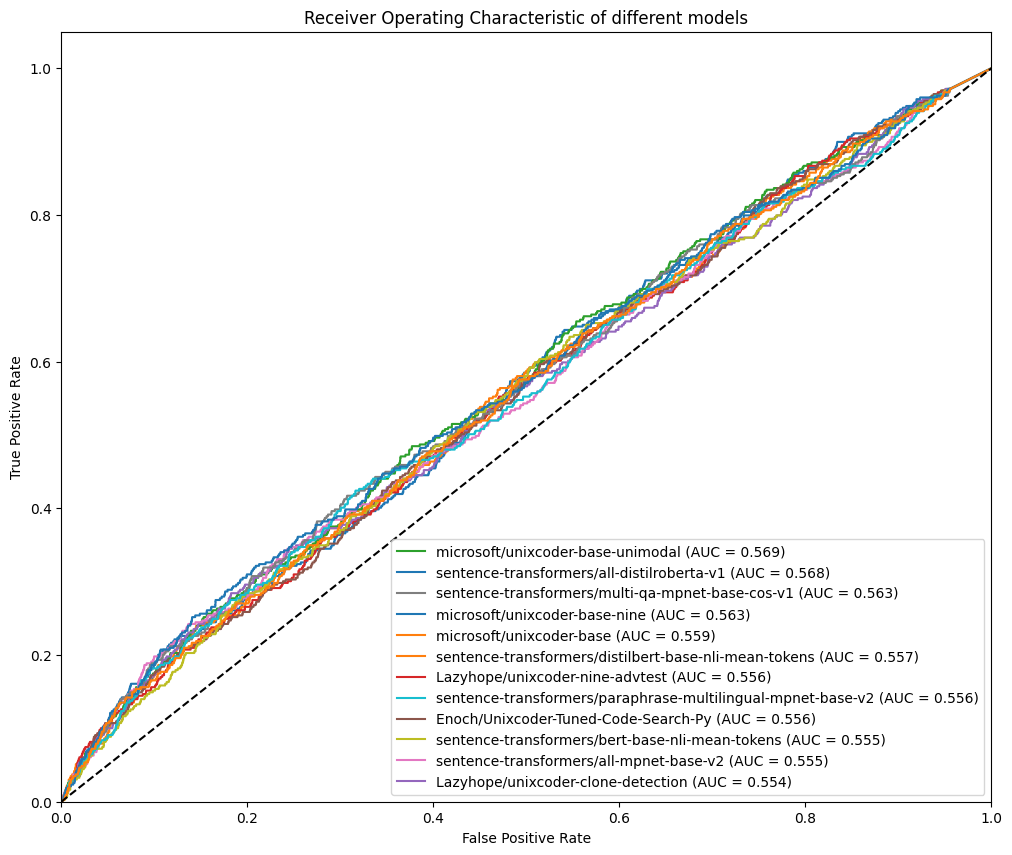

In [26]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

model_auc = {}
y_true = df['topic1'] == df['topic2']
fig = plt.figure(figsize=(12, 10))


def roc(model_name):
    y_score = df[model_name]
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    model_auc[model_name] = roc_auc

    plt.plot(fpr, tpr, label=model_name)


for model in models:
    roc(model)

# Order labels by each model's auc score
handles, labels = plt.gca().get_legend_handles_labels()
order = sorted(range(len(labels)), key=lambda k: -model_auc[labels[k]])
ordered_handles = [handles[idx] for idx in order]
ordered_labels = [f'{labels[idx]} (AUC = {model_auc[labels[idx]]:.3f})' for idx in order]
plt.legend(ordered_handles, ordered_labels, loc="lower right")

plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic of different models')
plt.savefig('roc_requirements_evaluation_train_315.eps')
plt.show()

In [27]:
model_auc

{'microsoft/unixcoder-base-nine': 0.5627094828232999,
 'microsoft/unixcoder-base': 0.559327066547725,
 'microsoft/unixcoder-base-unimodal': 0.569235894716252,
 'Lazyhope/unixcoder-nine-advtest': 0.5561349065816084,
 'Lazyhope/unixcoder-clone-detection': 0.5537966296747352,
 'Enoch/Unixcoder-Tuned-Code-Search-Py': 0.5555661108225054,
 'sentence-transformers/all-mpnet-base-v2': 0.5548616180729753,
 'sentence-transformers/multi-qa-mpnet-base-cos-v1': 0.5634882665845828,
 'sentence-transformers/bert-base-nli-mean-tokens': 0.5550634756668289,
 'sentence-transformers/paraphrase-multilingual-mpnet-base-v2': 0.5557310725282821,
 'sentence-transformers/all-distilroberta-v1': 0.5677372607674896,
 'sentence-transformers/distilbert-base-nli-mean-tokens': 0.5573203058516973}